# Seasonal Cycle Plotting

## Environment Settings

In [1]:
import warnings
warnings.filterwarnings("ignore") 

In [2]:
from dask_gateway import Gateway
from dask.distributed import Client
gateway = Gateway()
cluster = gateway.new_cluster()
cluster.adapt()
client = Client(cluster)
cluster

# # this block starts clusters we will need for fast parallel? calculations
# from dask_gateway import Gateway
# from dask.distributed import Client
# gateway = Gateway()
# cluster = gateway.new_cluster()
# cluster.adapt(minimum=2, maximum=20)
# client = Client(cluster)
# cluster

In [3]:
# cluster.close()
# client.close()

In [4]:
# !pip install --upgrade git+https://github.com/JiaweiZhuang/xESMF.git

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs # Pythonic file-system for Google Cloud Storage
import os.path
import xesmf as xe
from scipy.signal import detrend

In [6]:
# %matplotlib inline

# # global vars for time-series

# Time_months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec');
# # plt.rcParams['figure.figsize'] = 12, 6
# # %config InlineBackend.figure_format = 'retina'  #enabling 2x PNG matplotlib plots in the IPython notebook
# Colors = [[1, 1, 0], [1, 0.8, 0], [1, 0.6, 0], 
#           [1, 0.4, 0], [1, 0, 0], [1, 0.8, 1],
#           [1, 0.5, 1], [1, 0, 1], [0, 0, 0.5],
#           [0, 0, 1], [0, 0.5, 1], [0, 0.5, 0], 
#           [0, 1, 0], [0, 0.6, 0], [0.5, 0.2, 0]] 

# var_names=['phyc','chl','phydiat','zooc','intpp','epc100',
#            'fgco2','spco2','dfe','no3','si','rsntds']


# plot_titles=['Biomass (mol/m3)','Chlorophyll (kg/m3)','Diatom (mol/m3)', 
#              'Zooplankton (mol/m3)','Primary Production (mol/m2/s)','Export Production at 100m (mol/m2/s)',
#              'Air-sea CO2 flux (donward +) (gram C /m2/year)','SpCO2 (ppm)', 'Iron - Fe (mol/m3)', 
#              'Nitrate - NO3 (mol/m3)','Silica - Si (mol/m3)', 'Light - Surface Downward SW Radiation (W/m2)']

## Data Access

In [7]:
def get_data(df, var, model, expe, freq):
    try:
        uri = df[(df.variable_id == var) & \
                 (df.source_id == model) & \
                 (df.experiment_id == expe) & \
                 (df.table_id == freq)].zstore.values[0]
        gcs = gcsfs.GCSFileSystem(token='anon')
        ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
#         print(model, var, "found data")
    except:
        ds = []
        #print(model, var, "no data")
    return ds        

In [30]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
# models = ['CESM2', 'GFDL-CM4', 'GFDL-ESM4', 'CESM2-WACCM', 'IPSL-CM6A-LR', 'MRI-ESM2-0',
#           'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'UKESM1-0-LL',  'CanESM5', 'NorESM2-LM', 
#           'MPI-ESM1-2-HR', 'NorCPM1', 'MIROC-ES2L', 'CNRM-ESM2-1']
# models with ssp585 experiment
models = ['CESM2-WACCM','CESM2','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR', 
          'MRI-ESM2-0', 'UKESM1-0-LL','CanESM5-CanOE','CanESM5', 
          'NorESM2-LM', 'NorESM2-MM','MPI-ESM1-2-HR','MPI-ESM1-2-LR',
          'CNRM-ESM2-1', 'ACCESS-ESM1-5','MIROC-ES2L']


# models = ['CESM2-WACCM', 'GFDL-CM4']

# expe = 'ssp585'
# freq = 'Omon'
# start_year = '2081'
# end_year = '2100'
# var = 'chl'
# var2 = var+'os'

# xrays = []
# new_models = []

# for model in models:
#     print(model)
#     xray = get_data(df, var2, model, expe, freq)
#     xray1 = get_data(df, var, model, expe, freq) # no os
    
#     # if xray is not empty
#     if isinstance(xray, xr.Dataset): 
#         xrays.append(xray)  
#         new_models.append(model)
#     elif  isinstance(xray1, xr.Dataset): 
#         xrays.append(xray)  
#         new_models.append(model)
        
        
# xray_dic = {key:value for key, value in zip(new_models, xrays)}
# print(len(new_models))

In [31]:
# Another method for out grid:
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 91, 1.0)),
                     'lon': (['lon'], np.arange(0, 361, 1.0)),
                    }
                   )
ds_out

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 361)
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
Data variables:
    *empty*

## DATA for vars all models 12 average values per area (PAPA in NP and NABE - NA)

In [32]:
expe = 'historical'
freq = 'Omon'
start_year = '2003'
end_year = '2007'
var = 'zooc'
model = 'MPI-ESM1-2-HR'
vvar = var + 'os'
xray = get_data(df, vvar, model, expe, freq)
print(xray)
print('xray above')
if isinstance(xray, xr.Dataset):
        xxray_in = xray
        print('was')
else:
        vvar = var    
        xray = get_data(df, vvar, model, expe, freq)
        xxray_in= xray
            


[]
xray above


In [33]:
models = ['CESM2-WACCM','CESM2','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR', 
          'MRI-ESM2-0', 'UKESM1-0-LL','CanESM5-CanOE','CanESM5', 
          'NorESM2-LM', 'NorESM2-MM','MPI-ESM1-2-HR','MPI-ESM1-2-LR',
          'CNRM-ESM2-1', 'ACCESS-ESM1-5','MIROC-ES2L']

# models = ['CESM2-WACCM', 'GFDL-CM4']
# var_names=['phyc','chl','phydiat','zooc','tos']
# var_names = ['phyc', 'chl', 'phydiat', 'zooc','intpp','epc100','fgco2','spco2','dfe','no3','si','tos','omldamax','hfds','rsntds']
var_names = ['phyc','chl','phydiat','zooc','intpp','epc100','fgco2','spco2','dfe','no3','si','rsntds']
#
expe = 'historical'
freq = 'Omon'
start_year = '2003'
end_year = '2007'

#new_models = ['GISS-E2-1-G', 'GISS-E2-1-G-CC']
# new_vars = ['phydiat']   # new models aren't working here. 
xxray_in = []
# true_var = 'phydiat'
for model in models:
    print(model)
    for var in var_names:
        vvar = var + 'os'
        xray = get_data(df, vvar, model, expe, freq)
        if isinstance(xray, xr.Dataset):
            xxray_in = xray
            
        else:
            vvar = var    
            xray = get_data(df, vvar, model, expe, freq)
            xxray_in= xray
            
        if model == 'MPI-ESM1-2-HR' and (var == 'zooc' or var == 'si'):
            print('wont work')
        else:
            if isinstance(xxray_in, xr.Dataset):
                    ds = xxray_in.sel(time=slice(start_year, end_year))[vvar]

                    if 'latitude' in ds.coords:
                        ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
                    if 'nav_lat' in ds.coords:
                        ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})

                    if 'lev_partial' in ds.coords:
                        ds = ds.isel(lev_partial=0)
                    if 'olevel' in ds.coords:
                        ds = ds.isel(olevel=0)
                    if 'lev' in ds.coords:
                        ds = ds.isel(lev=0)

                    if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                        if var == 'phyc' or var == 'chl' or var == 'phydiat' or var == 'zooc' or var == 'no3' or var == 'si' or var == 'dfe':
                            ds = ds.where(ds>=0)

                    dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
                    dsr._grid_in = None
                    dsr._grid_out = None
                    dsr_out0 = dsr(ds)
                    dsr_out = xr.Dataset({var:dsr_out0})


                    if dsr_out[var].shape[0]==60: #5 years 12 months
                        print(var)
                        ds_np = dsr_out.sel(lat=slice(45,50)).sel(lon=slice(210,220)) #45 north, 210 east
                        dsm_np = ds_np[var].mean(dim='time',skipna=1)
                        anom_np = ds_np[var] - dsm_np
                        anom_np.load()
    #                     anom_detrended_np = xr.apply_ufunc(detrend, anom_np.fillna(0), anom_np.chunk({"lon":45,"lat":45}), kwargs={'axis': 0}).where(~anom_np.isnull())
                        anom_detrended_np = xr.apply_ufunc(detrend, anom_np.fillna(0).chunk({"lon":45,"lat":45}), kwargs={'axis': 0},dask="parallelized", output_dtypes=[anom_np.dtype]).where(~anom_np.isnull())
                        detrend_np = anom_detrended_np + dsm_np
                        do_np = detrend_np.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
#                         if var == 'spco2':
#                             do_np = do_np / 0.101325
#                         if var == 'phyc' or var == 'phycos':
#                             do_np = do_np * 12000 # more info
#                         if var == 'phycdiat'or var == 'phycdiatos':
#                             do_np = do_np * 12000 # more info
#                         if var == 'fgco2':
#                             do_np = do_np * 3600 * 24 * 365 * 1000 / (44/12) 

                        savef_np = '/home/jovyan/tempfolder/' + model + '_' + var + '_np.txt'
                        with open(savef_np, 'w') as npf:
                            for idata in do_np:
                                npf.write(str(idata) +"\n")

                        ds_na = dsr_out.sel(lat=slice(45,50)).sel(lon=slice(325,335))
                        dsm_na = ds_na[var].mean(dim='time', skipna=1)
                        anom_na = ds_na[var] - dsm_na
                        anom_na.load()
                        anom_detrended_na = xr.apply_ufunc(detrend, anom_na.fillna(0),kwargs={'axis': 0}, dask="parallelized", output_dtypes=[anom_na.dtype]).where(~anom_na.isnull())
                        detrend_na = anom_detrended_na + dsm_na
                        do_na = detrend_na.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
#                         if var == 'spco2':
#                             do_na = do_na / 0.101325
#                         if var == 'phyc' or var == 'phycos':
#                             do_na = do_na * 12000 # more info
#                         if var == 'phycdiat'or var == 'phycdiatos':
#                             do_na = do_na * 12000 # more info
#                         if var == 'fgco2':
#                             do_na = do_na * 3600 * 24 * 365 * 1000 / (44/12) 

                        savef_na = '/home/jovyan/tempfolder/' + model + '_' + var + '_na.txt'
                        with open(savef_na, 'w') as naf:
                            for idata in do_na:
                                naf.write(str(idata) +"\n")

#                 dsr.clean_weight_file()
                
#                 :~$ tar -czvf NA_NPssp585.tar.gz save

CESM2-WACCM
phyc
chl
phydiat
zooc
intpp
epc100
fgco2
spco2
dfe
no3
si
rsntds
CESM2
phyc
chl
phydiat
zooc
intpp
epc100
fgco2
spco2
dfe
no3
si
rsntds
GFDL-CM4
phyc
chl
fgco2
dfe
GFDL-ESM4
phyc
chl
phydiat
zooc
intpp
epc100
fgco2
spco2
dfe
no3
si
rsntds
IPSL-CM6A-LR
phyc
phydiat
zooc
intpp
epc100
fgco2
spco2
dfe
si
rsntds
MRI-ESM2-0
chl
intpp
epc100
fgco2
spco2
rsntds
UKESM1-0-LL
phyc
chl
phydiat
zooc
intpp
epc100
fgco2
spco2
dfe
no3
si
CanESM5-CanOE
phyc
chl
phydiat
zooc
intpp
epc100
fgco2
spco2
dfe
no3
rsntds
CanESM5
phyc
chl
zooc
intpp
epc100
fgco2
spco2
no3
rsntds
NorESM2-LM
phyc
chl
zooc
intpp
epc100
fgco2
spco2
dfe
no3
si
rsntds
NorESM2-MM
chl
fgco2
spco2
rsntds
MPI-ESM1-2-HR
phyc
chl
wont work
intpp
epc100
fgco2
spco2
dfe
no3
wont work
rsntds
MPI-ESM1-2-LR
phyc
chl
zooc
intpp
epc100
fgco2
spco2
dfe
no3
si
rsntds
CNRM-ESM2-1
phyc
phydiat
zooc
intpp
epc100
fgco2
spco2
dfe
no3
si
rsntds
ACCESS-ESM1-5
phyc
intpp
epc100
fgco2
spco2
dfe
no3
rsntds
MIROC-ES2L
phyc
chl
zooc
intpp
epc100
fg

In [14]:
xray

[]

In [34]:
print(do_np)

[ 38.66745885  67.57698859 108.3831158  158.91114841 186.36697828
 183.60200732 184.02766923 156.16933238 121.79931783  79.92221349
  47.12734344  31.5710989 ]


In [35]:
pwd

'/home/jovyan/PythonCodes1'

In [36]:
Time_months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec');
start_year = 2003
end_year = 2007
var_names=['phyc','chl','phydiat','zooc','intpp','epc100',
           'fgco2','spco2','dfe','no3','si','rsntds']
# var_names=['phyc']
           
models = ['CESM2-WACCM','CESM2','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR', 
          'MRI-ESM2-0', 'UKESM1-0-LL','CanESM5-CanOE','CanESM5', 
          'NorESM2-LM', 'NorESM2-MM','MPI-ESM1-2-HR','MPI-ESM1-2-LR',
          'CNRM-ESM2-1', 'ACCESS-ESM1-5','MIROC-ES2L']
# models = ['CESM2',  'GFDL-ESM4', 'ACCESS-ESM1-5', 'CESM2-WACCM','IPSL-CM6A-LR', 
#           'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'UKESM1-0-LL', 'CanESM5', 'NorESM2-LM',
#           'MPI-ESM1-2-HR', 'NorCPM1', 'MIROC-ES2L', 'CNRM-ESM2-1']

# models = ['CESM2-WACCM','GFDL-CM4']

plot_titles=['Biomass (mgC/m3)','Chlorophyll (kg/m3)','Diatom (mgC/m3)', 
             'Zooplankton (mgC/m3)','Primary Production (mgC/m2/s)','Export Production at 100m (mol/m2/s)',
             'Air-sea CO2 flux (donward +) (gram C /m2/year)','SpCO2 (ppm)', 'Iron - Fe (mol/m3)', 
             'Nitrate - NO3 (mol/m3)','Silica - Si (mol/m3)', 'Light - Surface Downward SW Radiation (W/m2)']
# plot_ranges=[[-0.001,0.0175], [-0.1e-6,3e-6], [-0.0005, 0.010], [-0.0005,0.008], 
plot_ranges=[[-0.001,180], [-0.1e-6,3e-6], [-0.0005, 120], [-0.0005,100],              
             [-0.05e-6,15e-3], [-0.1e-7,2.5e-7], [-60,85], [800, 1200],  
             [-0.1e-7,1e-6], [-0.001,0.0175], [-0.001,0.012], [0,250]]
Colors = [[1, 1, 0], [1, 0.8, 0], [1, 0.6, 0], [1, 0.4, 0], 
          [1, 0, 0], [1, 0.8, 1], [1, 0.5, 1], [1, 0, 1], 
          [0, 0, 0.5], [0, 0, 1], [0, 0.5, 1], [0, 0.5, 0], 
          [0, 1, 0], [0, 0.6, 0], [0.5, 0.2, 0], [0, 0.2, 0.5]] 

print(var_names)

['phyc', 'chl', 'phydiat', 'zooc', 'intpp', 'epc100', 'fgco2', 'spco2', 'dfe', 'no3', 'si', 'rsntds']


phyc
1
chl
2
phydiat
3
zooc
4
intpp
5
epc100
6
fgco2
7
spco2
8
dfe
9
no3
10
si
11
rsntds
12
CPU times: user 6.82 s, sys: 402 ms, total: 7.22 s
Wall time: 7.38 s


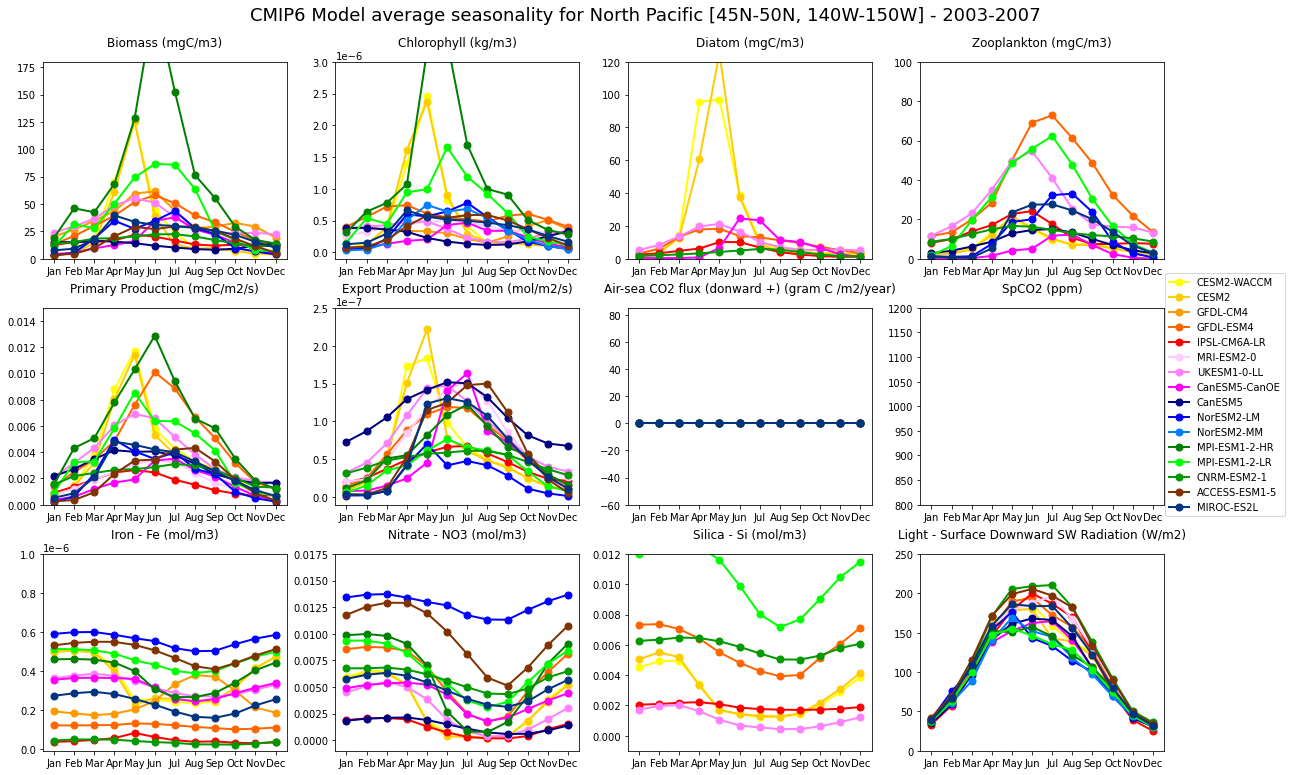

In [37]:
%%time

# plotting North Pacific

fig = plt.figure(figsize=(18, 11))
ncol = 3
nrow = 4
i = 0
# var_names = ['phydiat']
for var in var_names:
    
    
    i = i + 1
    ax = plt.subplot(ncol,nrow,i)
    print(var)
    mi = 0
    for model in models:
        
        ofn = '/home/jovyan/tempfolder/' + str(model) + '_' + str(var) + '_np.txt'
#         print(ofn)
        if os.path.exists(ofn):
#             print(os.path.exists(ofn))    
            dm = []
            with open(ofn, "r") as rf:
                
                for line in rf:
                    dm.append(float(line.strip()))
                    
            xmon = np.arange(1, 13)
            s = np.array(dm)

         ## DONE in regridding
            if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                if var == 'chl':
                    s = s * 0.001        # need more infromation, why???
            if var == 'phyc' or var=='phycos':
                s = s * 12000 # 
            if var == 'phydiat' or var == 'phydiatos':
                s = s * 12000 # 
            if var == 'zooc' or var == 'zoocos':
                s = s * 12000 # 
            if var == 'intpp': 
                s = s * 12000 #
            if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                if var == 'intpp':
                    s = -s             # need more infromation
                if var == 'fgco2':
                    s = s*(10**(-10))    # need more infromation
                if var == 'dfe':
                    xmon =[]
                    s = []        # need more infromation
                    
            plt.plot(xmon, s, c=Colors[mi], label=str(model), marker='o', markersize=7, linewidth=2.0)
#             
        else:
            plt.plot([], [], c=Colors[mi], label=str(model), marker='o', markersize=7,  linewidth=2.0)
#             print('check6')
        mi = mi +1
#         print(mi)
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
    print(i)
    plt.ylim(plot_ranges[i-1])
    plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,1000))
    plt.title(plot_titles[i-1], fontsize=12, y=1.05)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.90, top=0.91, hspace=0.25, wspace=0.20) # the amount of height/width reserved for space between subplots

fig.legend(models, loc='lower right', bbox_to_anchor=(0.997, 0.33)) 
plt.suptitle('CMIP6 Model average seasonality for North Pacific [45N-50N, 140W-150W] - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('/home/jovyan/quickplots/MultiVar_NP_2003-07_2.png', dpi=600)

In [38]:
print(s)

[ 38.66745885  67.57698859 108.3831158  158.91114841 186.36697828
 183.60200732 184.02766923 156.16933238 121.79931783  79.92221349
  47.12734344  31.5710989 ]


In [39]:
var

'rsntds'

1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
CPU times: user 7.07 s, sys: 281 ms, total: 7.35 s
Wall time: 7.5 s


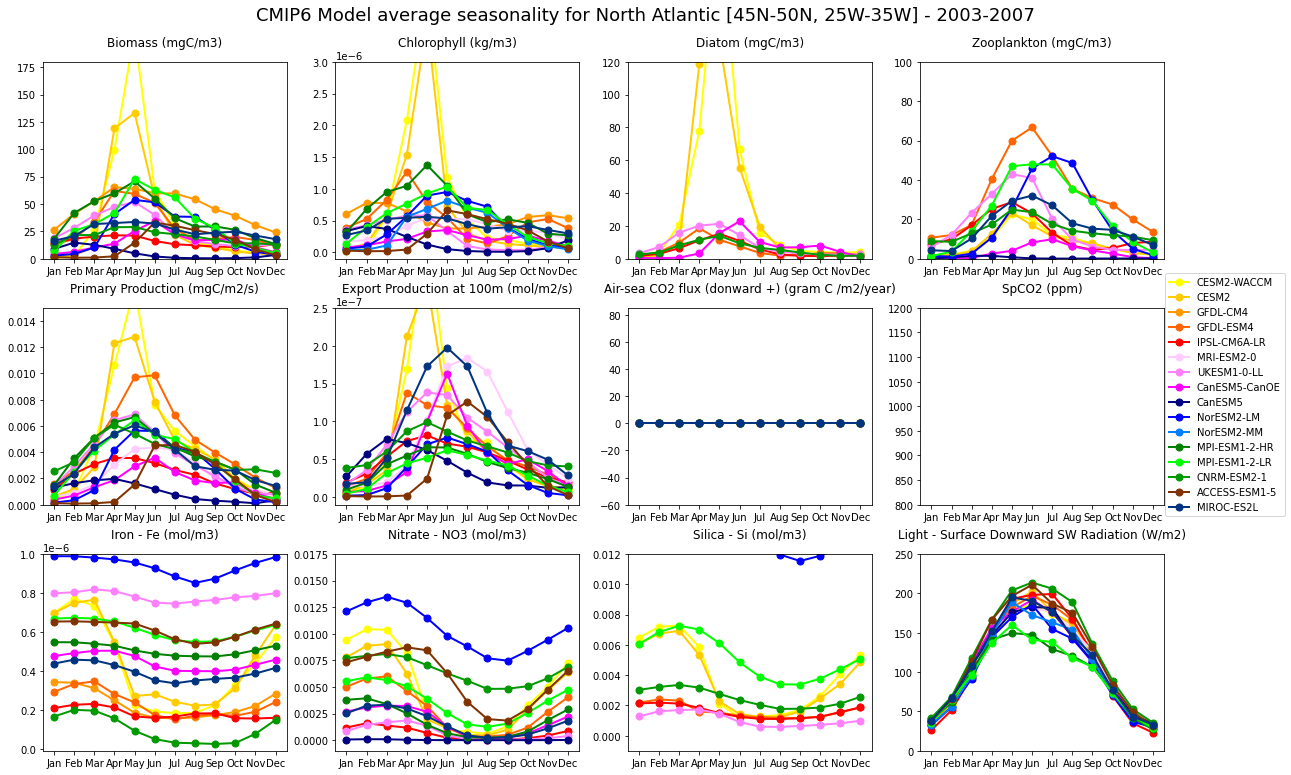

In [40]:
%%time

# plotting North Atlantic

fig = plt.figure(figsize=(18, 11))
ncol = 3
nrow = 4
i = 0
# var_names = ['phydiat']
for var in var_names:
    
    
    i = i + 1
    ax = plt.subplot(ncol,nrow,i)
    print(i)
    mi = 0
    for model in models:
        
        ofn = '/home/jovyan/tempfolder/' + str(model) + '_' + str(var) + '_na.txt'
        if os.path.exists(ofn):
#             print(os.path.exists(ofn))    
            dm = []
            with open(ofn, "r") as rf:
                
                for line in rf:
                    dm.append(float(line.strip()))
                    
            xmon = np.arange(1, 13)
            s = np.array(dm)
  
         ## DONE in regridding
            if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                if var == 'chl':
                    s = s * 0.001        # need more infromation, why???
            if var == 'phyc' or var=='phycos':
                s = s * 12000 # 
            if var == 'phydiat' or var == 'phydiatos':
                s = s * 12000 # 
            if var == 'zooc' or var == 'zoocos':
                s = s * 12000 # 
            if var == 'intpp': 
                s = s * 12000 #
            if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                if var == 'intpp':
                    s = -s             # need more infromation
                if var == 'fgco2':
                    s = s*(10**(-10))    # need more infromation
                if var == 'dfe':
                    xmon =[]
                    s = []        # need more infromation
                    

#             # done in regridding
#             if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
#                 if var == 'chl':
#                     s = s * 0.001        # need more infromation
#             if var == 'phyc':
#                 do_np = do_np * 12000 # more info
#             if var == 'phycdiat':
#                 do_np = do_np * 12000 # more info
#             # Done in regridding
#             if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
#                 if var == 'chl':
#                     s = s * 0.001        # need more infromation
#             if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
#                 if var == 'intpp':
#                     s = -s             # need more infromation
#                 if var == 'fgco2':
#                     s = s*(10**(-10))    # need more infromation
#                 if var == 'dfe':
#                     xmon =[]
#                     s = []        # need more infromation
                    
            plt.plot(xmon, s, c=Colors[mi], label=str(model), marker='o', markersize=7, linewidth=2.0)
#             
        else:
            plt.plot([], [], c=Colors[mi], label=str(model), marker='o', markersize=7,  linewidth=2.0)
#             print('check6')
        mi = mi +1
#         print(mi)
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
    print(i)
    plt.ylim(plot_ranges[i-1])
    plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,1000))
    plt.title(plot_titles[i-1], fontsize=12, y=1.05)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.90, top=0.91, hspace=0.25, wspace=0.20) # the amount of height/width reserved for space between subplots

fig.legend(models, loc='lower right', bbox_to_anchor=(0.997, 0.33)) 
plt.suptitle('CMIP6 Model average seasonality for North Atlantic [45N-50N, 25W-35W] - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('/home/jovyan/quickplots/MultiVar_NA_2003-07_2.png', dpi=600)  

## pCO2 Separation

In [ ]:
def get_data(df, var, model, expe, freq):
    try:
        uri = df[(df.variable_id == var) & \
                 (df.source_id == model) & \
                 (df.experiment_id == expe) & \
                 (df.table_id == freq)].zstore.values[0]
        gcs = gcsfs.GCSFileSystem(token='anon')
        ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
#         print(model, var, "found data")
    except:
        ds = []
        #print(model, var, "no data")
    return ds        

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
# models = ['CESM2', 'GFDL-CM4', 'GFDL-ESM4', 'CESM2-WACCM', 'IPSL-CM6A-LR', 'MRI-ESM2-0',
#           'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'UKESM1-0-LL',  'CanESM5', 'NorESM2-LM', 
#           'MPI-ESM1-2-HR', 'NorCPM1', 'MIROC-ES2L', 'CNRM-ESM2-1']
# models with ssp585 experiment
models = ['CESM2-WACCM','CESM2','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR', 
          'MRI-ESM2-0', 'UKESM1-0-LL','CanESM5-CanOE','CanESM5', 
          'NorESM2-LM', 'NorESM2-MM','MPI-ESM1-2-HR','MPI-ESM1-2-LR',
          'CNRM-ESM2-1', 'ACCESS-ESM1-5','MIROC-ES2L']

expe = 'ssp585'
freq = 'Omon'
start_year = '2081'
end_year = '2100'


In [ ]:
# Another method for out grid:
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 91, 1.0)),
                     'lon': (['lon'], np.arange(0, 361, 1.0)),
                    }
                   )
ds_out

In [ ]:
%%time
##  pCO2
# this works. gives 12 fields

# some models have time field as a cftime.DatetimeNoLeap, which soesn't behave as a common datetime object, (MRI-ESM2-0, for example)
# so due to the fact, that the sampling frequncy and the time period are the same we take the time field from any model that has it in datetime format
# here we use 'CESM-WACCM' model, but could be any, really. 
example_datetime = get_data(df, 'spco2', 'CESM2-WACCM', expe, freq)


# models = ['MRI-ESM2-0']

m_rgs = {}

# also I have encountered "recursion limit error", it is solved with limit extention from https://www.geeksforgeeks.org/python-handling-recursion-limit/
# however the code is rather to be optimized
import sys 
sys.setrecursionlimit(10**6)

for model in models:
    print(model)
    if model == 'MRI-ESM2-0': # we skip it because it has cftime.DatetimeNoLeap format
        continue

    sparay = get_data(df, 'spco2', model, expe, freq)
#     example_datetime = get_data(df, 'spco2', 'CESM2-WACCM', expe, freq)
    #print(sparay)
#     if model == 'MRI-ESM2-0':
#         sparay['time'] = example_datetime.time
#         print(sparay.time)
#         print('time')
    if isinstance(sparay, xr.Dataset):
        staray = get_data(df, 'tos', model, expe, freq)
        
        
        if not isinstance(staray, xr.Dataset):
            print(model, 'no tos, try thetao')
            staray = get_data(df, 'thetao', model, expe, freq)
            #print(staray)
            if not isinstance(staray, xr.Dataset):
                print(model, 'no sst data')
                continue
                
    else:
        continue
    
#     continue
    
    dsp = sparay.sel(time=slice(start_year, end_year))['spco2']
    
    if 'thetao' in staray:
        if 'lev_partial' in staray.coords:
            staray = staray.isel(lev_partial=0)
        if 'olevel' in staray.coords:
            staray = staray.isel(olevel=0)
        if 'lev' in staray.coords:
            staray = staray.isel(lev=0)
        if 'rho' in staray.coords:
            staray = staray.isel(rho=0)
        dst = staray.sel(time=slice(start_year, end_year))['thetao']
        
        #dst = dst.rename({'thetao':'tos'})
    else:
        dst = staray.sel(time=slice(start_year, end_year))['tos']
        
    if dst.shape[0] != 240:
        continue
    
    
    if 'latitude' in dsp.coords:
        dsp = dsp.rename({'longitude': 'lon', 'latitude': 'lat'})
        dst = dst.rename({'longitude': 'lon', 'latitude': 'lat'})
    if 'nav_lat' in dsp.coords:
        dsp = dsp.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
        dst = dst.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
    
    mrp = xe.Regridder(dsp, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
    mrp._grid_in = None
    mrp._grid_out = None
    dsp_out = mrp(dsp)        
    mrp.clean_weight_file()
   
    mrt = xe.Regridder(dst, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
    mrt._grid_in = None
    mrt._grid_out = None
    dst_out = mrt(dst)
    mrt.clean_weight_file()
    
    m_rg = xr.Dataset({'spco2':dsp_out, 'sst':dst_out})
    
    
    m_rgs[model] = m_rg
    
#     savet_np = 'save_co2/' + model + '_spco2_np.txt'
#     with open(savet_np, 'w') as nptf:
#         for idata in m_rg.spco2:
#             nptf.write(str(idata) +"\n")   
#     savet_np = 'save_co2/' + model + '_sst_np.txt'
#     with open(savet_np, 'w') as nptf:
#         for idata in m_rg.sst:
#             nptf.write(str(idata) +"\n") 
         
 

 

In [ ]:
## Detrending

# Mind NP and NA


monsp_t_nps = {}
monsp_nt_nps = {}
sst_nps =  {}
for model in models:
    print(model)
    if model == 'MRI-ESM2-0': # we skip it because it has cftime.DatetimeNoLeap format
        continue
    ## PAPA site ##
#     d_np = m_rgs[model].sel(lat=slice(45,50)).sel(lon=slice(210,220))     #NP
    d_np = m_rgs[model].sel(lat=slice(45,50)).sel(lon=slice(325,335))    #NA
            
    msp_np = d_np['spco2'].mean(dim='time',skipna=1) 
    anomsp_np = d_np['spco2'] - msp_np
    mst_np = d_np['sst'].mean(dim='time',skipna=1)
    anomst_np = d_np['sst'] - mst_np
            
#             anomsp_np.load()          
#             anomsp_detrended_np = xr.apply_ufunc(detrend, anomsp_np.fillna(0), kwargs={'axis': 0}).where(~anomsp_np.isnull())
    anomsp_detrended_np = xr.apply_ufunc(detrend, anomsp_np.fillna(0).chunk({"lon":45,"lat":45}), kwargs={'axis': 0},dask="parallelized", output_dtypes=[anomsp_np.dtype]).where(~anomsp_np.isnull())
            
    dtsp_np = anomsp_detrended_np + msp_np   
    dtsp_np = dtsp_np / 0.101325 
            
#             anomst_np.load()
#             anomst_detrended_np = xr.apply_ufunc(detrend, anomst_np.fillna(0), kwargs={'axis': 0}).where(~anomst_np.isnull())
    anomst_detrended_np = xr.apply_ufunc(detrend, anomst_np.fillna(0).chunk({"lon":45,"lat":45}), kwargs={'axis': 0},dask="parallelized", output_dtypes=[anomst_np.dtype]).where(~anomst_np.isnull())
#           
    dtst_np = anomst_detrended_np + mst_np      
            
    sp_temp_np = np.mean(dtsp_np) * np.exp(0.0423 * anomst_detrended_np)
    sp_ntemp_np = dtsp_np * np.exp( 0.0423 * (- anomst_detrended_np))       
            
    monsp_t_np = sp_temp_np.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1)
    monsp_nt_np = sp_ntemp_np.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1)
    sst_np = dtst_np.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1)
            
    print(model)
            
    monsp_t_nps[model] = monsp_t_np
    monsp_nt_nps[model] = monsp_nt_np
    sst_nps[model] = sst_np 


            
#     savet_np = 'save_co2/' + model + '_pco2-t_np.txt'   #NP
    savet_np = 'save_co2/' + model + '_pco2-t_na.txt'    #NA
    with open(savet_np, 'w') as nptf:
        for idata in monsp_t_np.values:
            nptf.write(str(idata) +"\n")        
    
#     savent_np = 'save_co2/' + model + '_pco2-nt_np.txt'     # NP
    savent_np = 'save_co2/' + model + '_pco2-nt_na.txt' #NA
    with open(savent_np, 'w') as npntf:
        for idata in monsp_nt_np.values:
            npntf.write(str(idata) +"\n")
            
#     savesst_np = 'save_co2/' + model + '_sst_np.txt'     #NP
    savesst_np = 'save_co2/' + model + '_sst_na.txt'      #NA
    with open(savesst_np, 'w') as npsstf:
        for idata in sst_np.values:
            npsstf.write(str(idata) +"\n")

            
#             tar -czvf NA_NP_CO2_Seasonal.tar.gz save_co2/


In [ ]:
%%time
# this works
Colors = [[1, 1, 0], [1, 0.8, 0], [1, 0.6, 0], 
          [1, 0.4, 0], [1, 0, 0], [1, 0.8, 1],
          [1, 0.5, 1], [1, 0, 1], [0, 0, 0.5],
          [0, 0, 1], [0, 0.5, 1], [0, 0.5, 0], 
          [0, 1, 0], [0, 0.6, 0], [0.5, 0.2, 0], [0.2, 0, 0.5]] 
models = ['CESM2-WACCM','CESM2','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR', 
          'MRI-ESM2-0', 'UKESM1-0-LL','CanESM5-CanOE','CanESM5', 
          'NorESM2-LM', 'NorESM2-MM','MPI-ESM1-2-HR','MPI-ESM1-2-LR',
          'CNRM-ESM2-1', 'ACCESS-ESM1-5','MIROC-ES2L']
pvars=['spco2', 'pco2-t', 'pco2-nt',
       'chl', 'sst', 'phyc',
       'dfe','no3']
ptitles=['pCO2 (ppm)', 'pCO2-T (ppm)', 'pCO2-nonT (ppm)', 
         'Chlorophyll (kg/m3)', 'SST (C)', 'Biomass (mol/m3)',
         'Iron - Fe (mol/m3)', 'Nitrate - NO3 (mol/m3)']  
# pranges=[[270, 485], [270, 485], [270, 485], 
#          [-0.1e-6, 5e-6], [4, 20], [-0.001,0.02],
#          [-0.1e-6, 1e-6], [-0.001, 0.012]]
pranges=[[700, 1500], [700,1500], [700,1500], 
         [-0.1e-6, 3e-6], [0, 25], [-0.001,0.02],
         [-0.1e-6, 1e-6], [-0.001, 0.018]]



fig = plt.figure(figsize=(15, 11))
ncol = 3
nrow = 3
i = 0
for var in pvars:
    print(var)
    i = i + 1
    ax = plt.subplot(ncol,nrow,i)
    
    mi = 0
    for model in models:
#         print(model)
        ofn = 'save/' + str(model) + '_' + str(var) + '_np.txt'
        if os.path.exists(ofn):
            
            dm = []
            with open(ofn, "r") as rf:
                for line in rf:
                    dm.append(float(line.strip()))
            
            xmon = np.arange(1, 13)
            s = np.array(dm)
            if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                if var == 'chl':
                    s = s * 0.001        # need more infromation
            if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                if var == 'intpp':
                    s = -s             # need more infromation
                if var == 'fgco2':
                    s = s*(10**(-10))    # need more infromation
                if var == 'dfe':
                    xmon =[]
                    s = []        # need more infromation
                    
            plt.plot(xmon, s, c=Colors[mi], label=str(model), 
                     marker='o', markersize=7, markerfacecolor='w', linewidth=2.0)
        else:
            plt.plot([], [], c=Colors[mi], label=str(model), 
                     marker='o', markersize=7, markerfacecolor='w', linewidth=2.0)
#         print(Colors[mi])    
        mi = mi +1
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
    plt.ylim(pranges[i-1])
    plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,1000))
    plt.title(ptitles[i-1], fontsize=12, y=1.05)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.90, top=0.91, hspace=0.25, wspace=0.20) # the amount of height/width reserved for space between subplots

fig.legend(models, loc='lower right', bbox_to_anchor=(0.8, 0.01)) 
plt.suptitle('CMIP6 SpCO2 separation and seasonal cylces - North Pacific [45N-50N, 140W-150W] - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('pCO2_sep_NP.png', dpi=600)    


In [ ]:
%%time
# North Atlantic
Colors = [[1, 1, 0], [1, 0.8, 0], [1, 0.6, 0], 
          [1, 0.4, 0], [1, 0, 0], [1, 0.8, 1],
          [1, 0.5, 1], [1, 0, 1], [0, 0, 0.5],
          [0, 0, 1], [0, 0.5, 1], [0, 0.5, 0], 
          [0, 1, 0], [0, 0.6, 0], [0.5, 0.2, 0], [0.2, 0, 0.5]] 
models = ['CESM2-WACCM','CESM2','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR', 
          'MRI-ESM2-0', 'UKESM1-0-LL','CanESM5-CanOE','CanESM5', 
          'NorESM2-LM', 'NorESM2-MM','MPI-ESM1-2-HR','MPI-ESM1-2-LR',
          'CNRM-ESM2-1', 'ACCESS-ESM1-5','MIROC-ES2L']
pvars=['spco2', 'pco2-t', 'pco2-nt',
       'chl', 'sst', 'phyc',
       'dfe','no3']
ptitles=['pCO2 (ppm)', 'pCO2-T (ppm)', 'pCO2-nonT (ppm)', 
         'Chlorophyll (kg/m3)', 'SST (C)', 'Biomass (mol/m3)',
         'Iron - Fe (mol/m3)', 'Nitrate - NO3 (mol/m3)']  
# pranges=[[270, 485], [270, 485], [270, 485], 
#          [-0.1e-6, 5e-6], [4, 20], [-0.001,0.02],
#          [-0.1e-6, 1e-6], [-0.001, 0.012]]
pranges=[[700, 1500], [700,1500], [700,1500], 
         [-0.1e-6, 3e-6], [0, 25], [-0.001,0.02],
         [-0.1e-6, 1e-6], [-0.001, 0.018]]



fig = plt.figure(figsize=(15, 11))
ncol = 3
nrow = 3
i = 0
for var in pvars:
    print(var)
    i = i + 1
    ax = plt.subplot(ncol,nrow,i)
    
    mi = 0
    for model in models:
#         print(model)
        ofn = 'save/' + str(model) + '_' + str(var) + '_na.txt'
        if os.path.exists(ofn):
            
            dm = []
            with open(ofn, "r") as rf:
                for line in rf:
                    dm.append(float(line.strip()))
            
            xmon = np.arange(1, 13)
            s = np.array(dm)
            if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                if var == 'chl':
                    s = s * 0.001        # need more infromation
            if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                if var == 'intpp':
                    s = -s             # need more infromation
                if var == 'fgco2':
                    s = s*(10**(-10))    # need more infromation
                if var == 'dfe':
                    xmon =[]
                    s = []        # need more infromation
                    
            plt.plot(xmon, s, c=Colors[mi], label=str(model), 
                     marker='o', markersize=7, markerfacecolor='w', linewidth=2.0)
        else:
            plt.plot([], [], c=Colors[mi], label=str(model), 
                     marker='o', markersize=7, markerfacecolor='w', linewidth=2.0)
#         print(Colors[mi])    
        mi = mi +1
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
    plt.ylim(pranges[i-1])
    plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,1000))
    plt.title(ptitles[i-1], fontsize=12, y=1.05)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.90, top=0.91, hspace=0.25, wspace=0.20) # the amount of height/width reserved for space between subplots

fig.legend(models, loc='lower right', bbox_to_anchor=(0.8, 0.01)) 
plt.suptitle('CMIP6 SpCO2 separation and seasonal cylces - North Atlantic [45N-50N, 25W-35W] - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('pCO2_sep_NA.png', dpi=600)    


# Average parameter value

In [ ]:
var_names=['phyc','chl','phydiat','zooc',
           'intpp','epc100','sst','mld',
           'fgco2','spco2','pco2-t','pco2-nt',
           'dfe','no3','si','rsntds']
plot_titles=['Biomass (mol/m3)','Chlorophyll (kg.m-3)','Diatom (mol/m3)', 'Zooplankton (mol/m3)',
             'Primary Prod. (mol.m-2.s-1)','Export Prod. (mol.m-2.s-1)',   'SST (C)',   'MLD (m)', 
             'Air-sea CO2 flux(gram C /m2/year)', 'SpCO2 (ppm)', 'SpCO2-T (ppm)', 'SpCO2-nonT (ppm)', 
             'Iron - Fe (mol/m3)', 'Nitrate - NO3 (mol/m3)','Silica - Si (mol/m3)', 'Light (W/m2)']  
plot_ranges=[[-0.0005,0.005], [-0.1e-6,1e-6],  [-0.0005, 0.0045],  [-0.001,0.005], 
             [-0.05e-6,0.6e-6], [-0.1e-7,1.5e-7], [6,15], [-1,450], 
             [-5,60], [310,380], [310,380], [310,380], 
             [-0.1e-6,1e-6], [-0.001,0.01], [-0.0025,0.015], [90,160]]

In [ ]:
%%time

fig = plt.figure(figsize=(15, 12.5))
ncol = 4
nrow = 4
i = 0
for var in var_names:
    i = i + 1
    if var == 'mld':
        continue
    
    ax = plt.subplot(ncol,nrow,i)
    
    mi = 0
    hs = []
    for model in models:
        
        ofnp = 'save/' + str(model) + '_' + str(var) + '_np.txt'
        ofna = 'save/' + str(model) + '_' + str(var) + '_na.txt'
        if os.path.exists(ofnp):
            if os.path.exists(ofna):
                
                np_data = []
                with open(ofnp, "r") as rfnp:
                    for line in rfnp:
                        np_data.append(float(line.strip()))
                        
                na_data = []
                with open(ofna, "r") as rfna:
                    for line in rfna:
                        na_data.append(float(line.strip()))
                        
                np_value = np.array(np_data)
                na_value = np.array(na_data)
                if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                    if var == 'chl':
                        np_value = np_value * 0.001        # need more infromation
                        na_value = na_value * 0.001
                if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                    if var == 'intpp':
                        np_value = -np_value             # need more infromation
                        na_value = -na_value
                    if var == 'fgco2':                  
                        np_value = np_value*(10**(-10))    # need more infromation
                        na_value = na_value*(10**(-10))
                    if var == 'dfe':
                        np_value = []
                        na_value = []        # need more infromation                                           
                        
                h = plt.scatter(np.mean(np_value), np.mean(na_value), s=100, marker='o', edgecolor = 'black',
                            color=Colors[mi], label=str(model))
        else:
            h = plt.scatter([], [], s=100, marker='o', edgecolor = 'black',
                        color=Colors[mi], label=str(model))
            
        mi = mi +1
        hs.append(h)
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
    
    plt.ylim(plot_ranges[i-1])
    plt.xlim(plot_ranges[i-1])
    #plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='both', style='sci', scilimits=(-2,1000))
    plt.title(plot_titles[i-1], fontsize=12.5, y=1.05)
    plt.plot([-1000,1000],[-1000,1000], 'k--', linewidth=0.75)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.88, top=0.91, hspace=0.35, wspace=0.25) # the amount of height/width reserved for space between subplots

fig.legend(hs, models, loc='lower right', bbox_to_anchor=(0.999, 0.03)) 
plt.suptitle('CMIP6 models - Average value for North Pacific (x-axis) and North Atlantic (y-axis) - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('/home/jovyan/quickplots/NAvsNP_average.png', dpi=600)    


In [ ]:
mmranges = [[-1,7.5], [-1,7.5],  [-1,7.5],  [-1,5], 
             [-1,5], [-1,7.5], [0,2], [-1,450], 
             [-1,10], [-0.1,0.8], [-0.1,0.8], [-0.1,0.8], 
             [-0.1,2.5], [-0.1,4], [-0.1,2.5], [-0.1,2.2]]

In [ ]:
# Behzad's range
mmranges = [[-0.01,9], [-0.01,9], [-0.01,9], [-0.01,9],
            [-0.01,4.7], [-0.01,4.7], [-0.01,1.3], [-1,9],     
            [-1,25], [-0.01,0.5], [-0.01,0.5], [-0.01,0.5], 
            [-0.01,2.3], [-0.01,4], [-0.01,2.3], [-0.01,2.3]]

In [ ]:
%%time

fig = plt.figure(figsize=(15, 12.5))
ncol = 4
nrow = 4
i = 0
for var in var_names:
    i = i + 1
    if var == 'mld':
        continue
    
    ax = plt.subplot(ncol,nrow,i)
    
    mi = 0
    hs = []
    for model in models:
        
        ofnp = 'save/' + str(model) + '_' + str(var) + '_np.txt'
        ofna = 'save/' + str(model) + '_' + str(var) + '_na.txt'
        if os.path.exists(ofnp):
            if os.path.exists(ofna):
                
                np_data = []
                with open(ofnp, "r") as rfnp:
                    for line in rfnp:
                        np_data.append(float(line.strip()))
                        
                na_data = []
                with open(ofna, "r") as rfna:
                    for line in rfna:
                        na_data.append(float(line.strip()))
                        
                np_value = np.array(np_data)
                na_value = np.array(na_data)
                if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                    if var == 'chl':
                        np_value = np_value * 0.001        # need more infromation
                        na_value = na_value * 0.001
                if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                    if var == 'intpp':
                        np_value = -np_value             # need more infromation
                        na_value = -na_value
                    if var == 'fgco2':                  
                        np_value = np_value*(10**(-10))    # need more infromation
                        na_value = na_value*(10**(-10))
                    if var == 'dfe':
                        np_value = []
                        na_value = []        # need more infromation                                           
                
                if np.shape(np_value)[0] > 0:
                    np_plot = (np.nanmax(np_value) - np.nanmin(np_value)) / np.nanmean(np_value)
                    na_plot = (np.nanmax(na_value) - np.nanmin(na_value)) / np.nanmean(na_value)
                    
                    h = plt.scatter(np_plot, na_plot, s=100, marker='o', edgecolor = 'black',
                            color=Colors[mi], label=str(model))
                else:
                    h = plt.scatter([], [], s=100, marker='o', edgecolor = 'black',
                            color=Colors[mi], label=str(model))
        else:
            h = plt.scatter([], [], s=100, marker='o', edgecolor = 'black',
                        color=Colors[mi], label=str(model))
            
        mi = mi +1
        hs.append(h)
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
    plt.plot([-1000,1000],[-1000,1000], 'k--', linewidth=0.75)
    plt.ylim(mmranges[i-1])
    plt.xlim(mmranges[i-1])
    #plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='both', style='sci', scilimits=(-3,1000))
    plt.title(plot_titles[i-1], fontsize=12.5, y=1)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.88, top=0.91, hspace=0.25, wspace=0.23) # the amount of height/width reserved for space between subplots

fig.legend(hs, models, loc='lower right', bbox_to_anchor=(0.999, 0.03)) 
plt.suptitle('CMIP6 models - Seasonality [(max-min)/ave] of North Pacific (x-axis) and North Atlantic (y-axis) - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('NAvsNP_max-min_ave.png', dpi=600)    


# pCO2 separation (model by model)


In [ ]:
%%time

## PAPA


fig = plt.figure(figsize=(18, 11))
ncol = 4
nrow = 4
i = 0
for model in models:
    
    f_pt = 'save/' + str(model) + '_pco2-t_np.txt'
    f_pnt = 'save/' + str(model) + '_pco2-nt_np.txt'
    f_p = 'save/' + str(model) + '_spco2_np.txt'
    
    if os.path.exists(f_pt):
        
        pco2_t = []
        with open(f_pt, "r") as rf:
            for line in rf:
                pco2_t.append(float(line.strip()))
        pco2_nt = []
        with open(f_pnt, "r") as rf:
            for line in rf:
                pco2_nt.append(float(line.strip()))
        pco2 = []
        with open(f_p, "r") as rf:
            for line in rf:
                pco2.append(float(line.strip()))
        
        xmon = np.arange(1, 13)
        
        i = i + 1
        ax = plt.subplot(ncol,nrow,i)
        
        plt.axhline(y=np.nanmean(pco2), color='k', linewidth=3.0)
        l1, = plt.plot(xmon, pco2, c='r', label='pCO2', 
                      marker='o', markersize=10, markerfacecolor='w', linewidth=4.0)
        l2, = plt.plot(xmon, pco2_t, c='b', label='pCO2-T', 
                      marker='o', markersize=10, markerfacecolor='w', linewidth=4.0)
        l3, = plt.plot(xmon, pco2_nt, c='g', label='pCO2-nonT',
                      marker='o', markersize=10, markerfacecolor='w', linewidth=4.0)
        plt.yticks(fontsize = 14)
        plt.ylim(700, 1500)
        plt.xticks(xmon, Time_months, rotation=45, fontsize=10) # Setting the X-ticks ## rotation='horizontal' # rotation='vertical'    
        plt.title(str(model), fontsize=14)
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.90, top=0.91, hspace=0.25, wspace=0.20) # the amount of height/width reserved for space between subplots

fig.legend([l1,l2,l3], ['pCO2', 'pCO2-T', 'pCO2-nonT'], loc='lower right', bbox_to_anchor=(0.8, 0.10)) 
plt.suptitle('CMIP6 SpCO2 separation (ppm) - North Pacific [45N-50N, 140W-150W] - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('pCO2_sep_model_NP.png', dpi=600)    


In [ ]:
%%time

## NAPA

fig = plt.figure(figsize=(18, 11))
ncol = 4
nrow = 4
i = 0

for model in models:
    
    f_pt = 'save/' + str(model) + '_pco2-t_na.txt'
    f_pnt = 'save/' + str(model) + '_pco2-nt_na.txt'
    f_p = 'save/' + str(model) + '_spco2_na.txt'
    
    if os.path.exists(f_pt):
        
        pco2_t = []
        with open(f_pt, "r") as rf:
            for line in rf:
                pco2_t.append(float(line.strip()))
        pco2_nt = []
        with open(f_pnt, "r") as rf:
            for line in rf:
                pco2_nt.append(float(line.strip()))
        pco2 = []
        with open(f_p, "r") as rf:
            for line in rf:
                pco2.append(float(line.strip()))
        
        xmon = np.arange(1, 13)
        
        i = i + 1
        ax = plt.subplot(ncol,nrow,i)
        
        plt.axhline(y=np.nanmean(pco2), color='k', linewidth=3.0)
        l1, = plt.plot(xmon, pco2, c='r', label='pCO2', 
                      marker='o', markersize=10, markerfacecolor='w', linewidth=4.0)
        l2, = plt.plot(xmon, pco2_t, c='b', label='pCO2-T', 
                      marker='o', markersize=10, markerfacecolor='w', linewidth=4.0)
        l3, = plt.plot(xmon, pco2_nt, c='g', label='pCO2-nonT',
                      marker='o', markersize=10, markerfacecolor='w', linewidth=4.0)
        plt.yticks(fontsize = 14)
        plt.ylim(700, 1500)
        plt.xticks(xmon, Time_months, rotation=45, fontsize=10) # Setting the X-ticks ## rotation='horizontal' # rotation='vertical'    
        plt.title(str(model), fontsize=14)
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.90, top=0.91, hspace=0.25, wspace=0.20) # the amount of height/width reserved for space between subplots

fig.legend([l1,l2,l3], ['pCO2', 'pCO2-T', 'pCO2-nonT'], loc='lower right', bbox_to_anchor=(0.8, 0.10)) 
plt.suptitle('CMIP6 SpCO2 separation (ppm) - North Atlantic [45N-50N, 25W-35W] - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('pCO2_sep_model_NA.png', dpi=600)    


# Zoo / biomass & Diatom / biomass

In [ ]:
for model in models:
    
    paray = get_data(df, 'phyc', model, expe, freq)
    if not isinstance(paray, xr.Dataset):
        continue
    
    n = 0
    zaray = get_data(df, 'zooc', model, expe, freq)
    daray = get_data(df, 'phydiat', model, expe, freq)
    if isinstance(zaray, xr.Dataset):
        n = n + 1
    if isinstance(daray, xr.Dataset):
        n = n + 1
    print(model, n)

In [ ]:

# models are loaded in chunks
# models = ['CESM2-WACCM','CESM2','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR'] 
# models =  ['MRI-ESM2-0', 'UKESM1-0-LL','CanESM5-CanOE','CanESM5'] 
# models =  ['NorESM2-LM', 'NorESM2-MM','MPI-ESM1-2-HR','MPI-ESM1-2-LR']
models =  ['CNRM-ESM2-1', 'ACCESS-ESM1-5','MIROC-ES2L','MPI-ESM1-2-HR','MPI-ESM1-2-LR']
expe = 'ssp585'
freq = 'Omon'
start_year = '2081'
end_year = '2100'

In [ ]:
%%time

# code should be run with 3-5  models at a time. Pangeo crushes
for model in models:
    print(model)
    if model == 'MRI-ESM2-0':
        continue
    
    paray = get_data(df, 'phyc', model, expe, freq)
    if not isinstance(paray, xr.Dataset):
        continue
    
    n = 0
    zaray = get_data(df, 'zooc', model, expe, freq)
    daray = get_data(df, 'phydiat', model, expe, freq)
    if isinstance(zaray, xr.Dataset):
        n = n + 1
    if isinstance(daray, xr.Dataset):
        n = n + 1
    
    if n == 0:
        continue            
            
    dp = paray.sel(time=slice(start_year, end_year))['phyc']
    
    if 'lev_partial' in dp.coords:
        dp = dp.isel(lev_partial=0)
    if 'olevel' in dp.coords:
        dp = dp.isel(olevel=0)
    if 'lev' in dp.coords:
        dp = dp.isel(lev=0)
    
    if 'latitude' in dp.coords:
        dp = dp.rename({'longitude': 'lon', 'latitude': 'lat'})
    if 'nav_lat' in dp.coords:
        dp = dp.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
    
    regridder = xe.Regridder(dp, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
    regridder._grid_in = None
    regridder._grid_out = None
    
    if isinstance(zaray, xr.Dataset):
        dz = zaray.sel(time=slice(start_year, end_year))['zooc']
        
        if 'lev_partial' in dz.coords:
            dz = dz.isel(lev_partial=0)
        if 'olevel' in dz.coords:
            dz = dz.isel(olevel=0)
        if 'lev' in dz.coords:
            dz = dz.isel(lev=0)
            
        if 'latitude' in dz.coords:
            dz = dz.rename({'longitude': 'lon', 'latitude': 'lat'})
        if 'nav_lat' in dz.coords:
            dz = dz.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
        
        zp_ratio = dz/dp
        
        
        zp_ratio_out = regridder(zp_ratio)
        zpr = xr.Dataset({'zpr':zp_ratio_out})
        
        if zpr['zpr'].shape[0]==240:
            #PAPA
            zpr_np = zpr.sel(lat=slice(45,50)).sel(lon=slice(210,220))
            
            mzpr_np = zpr_np['zpr'].mean(dim='time', skipna=1)
            anomzpr_np = zpr_np['zpr'] - mzpr_np
            anomzpr_np.load()
#             anomzpr_detrended_np = xr.apply_ufunc(detrend, anomzpr_np, 
#                                                  kwargs={'axis': 0}).where(~anomzpr_np.isnull())
            anomzpr_detrended_np = xr.apply_ufunc(detrend, anomzpr_np.chunk({"lon":45,"lat":45}), kwargs={'axis': 0},dask="parallelized", output_dtypes=[anomzpr_np.dtype]).where(~anomzpr_np.isnull())
            zpr_detrend_np = anomzpr_detrended_np + mzpr_np
            vzpr_np = zpr_detrend_np.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
            
            savef_np = 'save_DZ/' + model + '_zpr_np.txt'
            with open(savef_np, 'w') as npf:
                for idata in vzpr_np:
                    npf.write(str(idata) +"\n")
            
            #NABA
            zpr_na = zpr.sel(lat=slice(45,50)).sel(lon=slice(325,335))
            mzpr_na = zpr_na['zpr'].mean(dim='time',skipna=1)
            anomzpr_na = zpr_na['zpr'] - mzpr_na
            anomzpr_na.load()
#             anomzpr_detrended_na = xr.apply_ufunc(detrend, anomzpr_na,
#                                                  kwargs={'axis': 0}).where(~anomzpr_na.isnull())
            anomzpr_detrended_na = xr.apply_ufunc(detrend, anomzpr_na.chunk({"lon":45,"lat":45}), kwargs={'axis': 0},dask="parallelized", output_dtypes=[anomzpr_na.dtype]).where(~anomzpr_na.isnull())
            zpr_detrend_na = anomzpr_detrended_na + mzpr_na
            vzpr_na = zpr_detrend_na.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
            
            savef_na = 'save_DZ/' + model + '_zpr_na.txt'
            with open(savef_na, 'w') as naf:
                for idata in vzpr_na:
                    naf.write(str(idata) +"\n")
                        
    if isinstance(daray, xr.Dataset):
        dd = daray.sel(time=slice(start_year, end_year))['phydiat']
        
        if 'lev_partial' in dd.coords:
            dd = dd.isel(lev_partial=0)
        if 'olevel' in dd.coords:
            dd = dd.isel(olevel=0)
        if 'lev' in dz.coords:
            dd = dd.isel(lev=0)
            
        if 'latitude' in dd.coords:
            dd = dd.rename({'longitude': 'lon', 'latitude': 'lat'})
        if 'nav_lat' in dd.coords:
            dd = dd.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
        
        d_frac = dd/dp
        
        d_frac_out = regridder(d_frac)
        dfrac = xr.Dataset({'dfrac':d_frac_out})
        
        if dfrac['dfrac'].shape[0]==240:
            #PAPA
            df_np = dfrac.sel(lat=slice(45,50)).sel(lon=slice(210,220))
            mdf_np = df_np['dfrac'].mean(dim='time', skipna=1)
            anomdf_np = df_np['dfrac'] - mdf_np
            anomdf_np.load()
#             anomdf_detrended_np = xr.apply_ufunc(detrend, anomdf_np, 
#                                                  kwargs={'axis': 0}).where(~anomdf_np.isnull())
            anomdf_detrended_np = xr.apply_ufunc(detrend, anomdf_np.chunk({"lon":45,"lat":45}), kwargs={'axis': 0},dask="parallelized", output_dtypes=[anomdf_np.dtype]).where(~anomdf_np.isnull())
            df_detrend_np = anomdf_detrended_np + mdf_np
            vdf_np = df_detrend_np.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
            
            savef_np = 'save_DZ/' + model + '_dfrac_np.txt'
            with open(savef_np, 'w') as npf:
                for idata in vdf_np:
                    npf.write(str(idata) +"\n")
            
            #NABA
            df_na = dfrac.sel(lat=slice(45,50)).sel(lon=slice(325,335))
            mdf_na = df_na['dfrac'].mean(dim='time',skipna=1)
            anomdf_na = df_na['dfrac'] - mdf_na
            anomdf_na.load()
#             anomdf_detrended_na = xr.apply_ufunc(detrend, anomdf_na,
#                                                  kwargs={'axis': 0}).where(~anomdf_na.isnull())
            anomdf_detrended_na = xr.apply_ufunc(detrend, anomdf_na.chunk({"lon":45,"lat":45}), kwargs={'axis': 0},dask="parallelized", output_dtypes=[anomdf_na.dtype]).where(~anomdf_na.isnull())
            df_detrend_na = anomdf_detrended_na + mdf_na
            vdf_na = df_detrend_na.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
            
            savef_na = 'save_DZ/' + model + '_dfrac_na.txt'
            with open(savef_na, 'w') as naf:
                for idata in vdf_na:
                    naf.write(str(idata) +"\n")
    
    regridder.clean_weight_file()


In [ ]:
%%time

models = ['CESM2-WACCM','CESM2','GFDL-CM4','GFDL-ESM4','IPSL-CM6A-LR', 
          'MRI-ESM2-0', 'UKESM1-0-LL','CanESM5-CanOE','CanESM5', 
          'NorESM2-LM', 'NorESM2-MM','MPI-ESM1-2-HR','MPI-ESM1-2-LR',
          'CNRM-ESM2-1', 'ACCESS-ESM1-5','MIROC-ES2L']
Colors = [[1, 1, 0], [1, 0.8, 0], [1, 0.6, 0], [1, 0.4, 0], 
          [1, 0, 0], [1, 0.8, 1], [1, 0.5, 1], [1, 0, 1], 
          [0, 0, 0.5], [0, 0, 1], [0, 0.5, 1], [0, 0.5, 0], 
          [0, 1, 0], [0, 0.6, 0], [0.5, 0.2, 0], [0, 0.2, 0.5]] 


var2 = ['dfrac', 'zpr']
v2ranges = [[-0.01,4.1],[-0.01,4.1]]
v2titles = ['Diatom%', 'Zooplankton/Phytoplankton']

fig = plt.figure(figsize=(15, 12.5))
ncol = 4
nrow = 4
i = 0
for var in var2:
    i = i + 1
    
    ax = plt.subplot(ncol,nrow,i)
    
    mi = 0
    hs = []
    for model in models:
        print(model)
        ofnp = 'save_DZ/' + str(model) + '_' + str(var) + '_np.txt'
        ofna = 'save_DZ/' + str(model) + '_' + str(var) + '_na.txt'
        if os.path.exists(ofnp):
#             print(ofnp)
            if os.path.exists(ofna):
#                 print(ofnp)
                np_data = []
                with open(ofnp, "r") as rfnp:
                    for line in rfnp:
                        np_data.append(float(line.strip()))
                        
                na_data = []
                with open(ofna, "r") as rfna:
                    for line in rfna:
                        na_data.append(float(line.strip()))
                        
                np_value = np.array(np_data)
                na_value = np.array(na_data)

                if np.shape(np_value)[0] > 0:
                    np_plot = (np.nanmax(np_value) - np.nanmin(np_value)) / np.nanmean(np_value)
                    na_plot = (np.nanmax(na_value) - np.nanmin(na_value)) / np.nanmean(na_value)
                    
                    h = plt.scatter(np_plot, na_plot, s=100, marker='o', edgecolor = 'black',
                            color=Colors[mi], label=str(model))
                else:
                    h = plt.scatter([], [], s=100, marker='o', edgecolor = 'black',
                            color=Colors[mi], label=str(model))
        else:
            h = plt.scatter([], [], s=100, marker='o', edgecolor = 'black',
                        color=Colors[mi], label=str(model))
            
        mi = mi +1
        hs.append(h)
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
    plt.plot([-1000,1000],[-1000,1000], 'k--', linewidth=0.75)
    plt.ylim(v2ranges[i-1])
    plt.xlim(v2ranges[i-1])
    #plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='both', style='sci', scilimits=(-3,1000))
    plt.title(v2titles[i-1], fontsize=12.5, y=1)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.88, top=0.91, hspace=0.25, wspace=0.23) # the amount of height/width reserved for space between subplots

fig.legend(hs, models, loc='lower right', bbox_to_anchor=(0.999, 0.03)) 
plt.suptitle('CMIP6 models - Seasonality [(max-min)/ave] of North Pacific (x-axis) and North Atlantic (y-axis) - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('NA_NP_max-min_ave_diaf_zoor.png', dpi=600)    


In [ ]:
%%time

var2 = ['dfrac', 'zpr']
v2ranges = [[-0.01,1.01],[-0.01,1.01]]
v2titles = ['Diatom %', 'Zooplankton / Phytoplankton']



fig = plt.figure(figsize=(15, 12.5))
ncol = 4
nrow = 4
i = 0
for var in var2:
    i = i + 1
    
    ax = plt.subplot(ncol,nrow,i)
    
    mi = 0
    hs = []
    for model in models:
        
        ofnp = 'save_DZ/' + str(model) + '_' + str(var) + '_np.txt'
        ofna = 'save_DZ/' + str(model) + '_' + str(var) + '_na.txt'
        if os.path.exists(ofnp):
            if os.path.exists(ofna):
                
                np_data = []
                with open(ofnp, "r") as rfnp:
                    for line in rfnp:
                        np_data.append(float(line.strip()))
                        
                na_data = []
                with open(ofna, "r") as rfna:
                    for line in rfna:
                        na_data.append(float(line.strip()))
                        
                np_value = np.array(np_data)
                na_value = np.array(na_data)
                
                h = plt.scatter(np.mean(np_value), np.mean(na_value), s=100, marker='o', edgecolor = 'black',
                            color=Colors[mi], label=str(model))
        else:
            h = plt.scatter([], [], s=100, marker='o', edgecolor = 'black',
                        color=Colors[mi], label=str(model))
            
        mi = mi +1
        hs.append(h)
    #plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
    
    plt.ylim(v2ranges[i-1])
    plt.xlim(v2ranges[i-1])
    #plt.xticks(np.arange(1, 13), Time_months)
    ax.ticklabel_format(axis='both', style='sci', scilimits=(-2,1000))
    plt.title(v2titles[i-1], fontsize=12.5, y=1.05)
    plt.plot([-1000,1000],[-1000,1000], 'k--', linewidth=0.75)
    
    
plt.subplots_adjust(left=0.035, bottom=0.04, right=0.88, top=0.91, hspace=0.35, wspace=0.25) # the amount of height/width reserved for space between subplots

fig.legend(hs, models, loc='lower right', bbox_to_anchor=(0.999, 0.03)) 
plt.suptitle('CMIP6 models - Average value for North Pacific (x-axis) and North Atlantic (y-axis) - '+ str(start_year) + '-' + str(end_year), fontsize=18)

plt.savefig('NA_NP_average_diaf_zoor.png', dpi=600)    


## Data Pre-processing
    1. Regridding

In [ ]:
def func_detrend_3d(Var_orig):  
    from scipy import stats
    
    lat_n=Var_orig.shape[1]
    lon_n=Var_orig.shape[2] 
    time_n=Var_orig.shape[0]    
    detrend_mat = empty((time_n,lat_n,lon_n)) * nan
    
    Var_orig_mean=np.nanmean(Var_orig,axis=0)
    
    for ii in range(0,lat_n):
        for jj in range(0,lon_n):
            if np.logical_not(np.isnan(Var_orig_mean[ii,jj])): # If this grid cell has data and is non NaN
                
                yy=Var_orig[:,ii,jj]
                xx=np.asarray(range(1,time_n+1))              
                yy=yy[np.logical_not(np.isnan(xx))] ; xx=xx[np.logical_not(np.isnan(xx))] # Excluding any NaN values in the time series 
                xx=xx[np.logical_not(np.isnan(yy))] ; yy=yy[np.logical_not(np.isnan(yy))] # Excluding any NaN values in the time series 
               
                m_slope, b_intercept, r_val, p_val, std_err = stats.linregress(xx, yy)
                
                xx=np.asarray(range(1,time_n+1))                  
                detrend_mat[:,ii,jj] = m_slope*xx

    Var_detrend=Var_orig-detrend_mat
                
    return Var_detrend    

In [ ]:
##################################
###   3D Plotting - Subplots  ####
##################################
GCM_Names =models
Time_months = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec');     
colors_months = ['navy', 'blue', 'royalblue', 'lime', 'limegreen', 'green', 'yellow', 'gold', 'orange', 'red', 'magenta','darkviolet']
#### Plots 1 #####
var_names_z=[ 'Phyc_allmonths',                                         'PPint_allmonths',                                       'Zooc_allmonths',                                    'EPC100_allmonths'             ]
var_names_x=[ 'Fe_allmonths',                                           'Fe_allmonths',                                          'Fe_allmonths',                                      'Fe_allmonths'                ]
var_names_y=[ 'NO3_allmonths',                                          'NO3_allmonths',                                         'NO3_allmonths',                                     'NO3_allmonths'              ]
plot_titles=[ 'log [biomass vs. Iron (Fe) vs. Nitrate (NO3)] [mol/m3]', 'log [intPP vs. Iron (Fe) vs. Nitrate (NO3)] [mol/m3]', 'log [Zoo vs. Iron (Fe) vs. Nitrate (NO3)] [mol/m3]', 'log [EPC 100m vs. Iron (Fe) vs. Nitrate (NO3)] [mol/m3]'   ]
save_names= [ 'Phyc_vs_Fe_vs_NO3',                                      'PPint_vs_Fe_vs_NO3',                                    'Zooc_vs_Fe_vs_NO3',                                 'EPC100_vs_Fe_vs_NO3'                 ]  

file_names_z=[ 'bio',                                                    'bio',                                                   'bio',                                              'bio'                 ]
file_names_x=[ 'bio',                                                    'bio',                                                   'bio',                                              'bio'                  ]
file_names_y=[ 'bio',                                                    'bio',                                                   'bio',                                              'bio'                  ]
#### Plots 1 #####
var_names_z=[ 'Phyc_allmonths',                                     'PPint_allmonths',                                  'Zooc_allmonths',                                 'EPC100_allmonths'             ]
var_names_x=[ 'RSNTDS_allmonths',                                   'RSNTDS_allmonths',                                 'RSNTDS_allmonths',                               'RSNTDS_allmonths'             ]
var_names_y=[ 'MLD_allmonths',                                      'MLD_allmonths',                                    'MLD_allmonths',                                  'MLD_allmonths'                ]
plot_titles=[ 'log (biomass)[mol/m3] vs. light [w/m2] vs. MLD [m]', 'log (intPP)[mol/m3] vs. light [w/m2] vs. MLD [m]', 'log (Zoo)[mol/m3] vs. light [w/m2] vs. MLD [m]', 'log (EPC 100m)[mol/m3] vs. light [w/m2] vs. MLD [m]'   ]
save_names= [ 'Phyc_vs_RSNTDS_vs_MLD',                              'PPint_vs_RSNTDS_vs_MLD',                           'Zooc_vs_RSNTDS_vs_MLD',                          'EPC100_vs_RSNTDS_vs_MLD'                 ]  

file_names_z=[ 'bio',                                               'bio',                                              'bio',                                            'bio'                      ]
file_names_x=[ 'physics',                                           'physics',                                          'physics',                                        'physics'                  ]
file_names_y=[ 'physics',                                           'physics',                                          'physics',                                        'physics'                  ]

#plot_ranges_y=[[0,0.006],  [-2, -7]]
#plot_ranges_x=[[0,0.006],  [-1, -7]]

legend_markers = [Line2D([0], [0], color=cmap(0.), lw=4),
                Line2D([0], [0], color=cmap(.5), lw=4),
                Line2D([0], [0], color=cmap(1.), lw=4)]

In [ ]:
var_names=['phyc','chl','phydiat','zooc',
           'intpp','epc100','sst','mld',
           'fgco2','spco2','pco2-t','pco2-nt',
           'dfe','no3','si','rsntds']
var_y_names = 'chl'   # vars for x axis (the same for a set of plots) Why do i need a list??
var_z_names = 'no3'

plot_titles=['Biomass (mol/m3)','Chlorophyll (kg.m-3)','Diatom (mol/m3)', 'Zooplankton (mol/m3)',
             'Primary Prod. (mol.m-2.s-1)','Export Prod. (mol.m-2.s-1)',   'SST (C)',   'MLD (m)', 
             'Air-sea CO2 flux(gram C /m2/year)', 'SpCO2 (ppm)', 'SpCO2-T (ppm)', 'SpCO2-nonT (ppm)', 
             'Iron - Fe (mol/m3)', 'Nitrate - NO3 (mol/m3)','Silica - Si (mol/m3)', 'Light (W/m2)']  
plot_ranges=[[-0.0005,0.005], [-0.1e-6,1e-6],  [-0.0005, 0.0045],  [-0.001,0.005], 
             [-0.05e-6,0.6e-6], [-0.1e-7,1.5e-7], [6,15], [-1,450], 
             [-5,60], [310,380], [310,380], [310,380], 
             [-0.1e-6,1e-6], [-0.001,0.01], [-0.0025,0.015], [90,160]]

In [ ]:
import shelve 
from numpy import zeros, ones, empty, nan, shape
from numpy import isnan, nanmean, nanmax, nanmin
import numpy.ma as ma
from matplotlib.lines import Line2D

expe = 'ssp585'
freq = 'Omon'
start_year = '2081' #!!!! watch out!! changes with expe
end_year = '2100'
yrs_n=20

d_trend='yes'
n_r=4 ; n_c=4 ;
n_t=len(models)
box_n='PAPA'   ;  # box_n='NABE'
GCM_Names =models

# for V_i in range(n_t): # V_i=0   V_i=1    V_i=2    V_i=3    V_i=4    V_i=5    V_i=6    V_i=7    V_i=8    V_i=9    V_i=10    V_i=11    V_i=12    V_i=13
for V_i in range (0,1,1):
    if d_trend=='yes':
        if box_n=='PAPA':
            P_title=plot_titles[V_i]+' - North Pacific [45N-50N, 140W-150W] - '+str(start_year)+'-'+str(end_year)+' - detrended'
        elif box_n=='NABE':
            P_title=plot_titles[V_i]+' - North Atlantic [45N-50N, 25W-35W] - '+str(start_year)+'-'+str(end_year)+' - detrended'
    else:
        if box_n=='PAPA':
            P_title=plot_titles[V_i]+' - North Pacific [45N-50N, 140W-150W] - '+str(start_year)+'-'+str(end_year)
        elif box_n=='NABE':
            P_title=plot_titles[V_i]+' - North Atlantic [45N-50N, 25W-35W] - '+str(start_year)+'-'+str(end_year)
    
    fig=plt.figure(figsize=(17, 15))  # width, height
    for M_i in range(len(GCM_Names)): # M_i=1     # GCM=GCM_Names[0]

        GCM=GCM_Names[M_i]
        print (GCM) 
        
        ax = fig.add_subplot(n_r,n_c,M_i+1,projection='3d') 
        ax_position = ax.get_position()
        ax.set_position([ax_position.x0-0.01,  
                         ax_position.y0+0.075, 
                         ax_position.width*1.1, 
                         ax_position.height*1.1]) 
#         print(ax.get_position())
#         ax.set_position([[ax_position[0,0],],[,]])
#         ax.set_aspect("auto")
        filename_in = ('/home/jovyan//CMIP6-Codes/save_fields/' + GCM + '_'+expe+'.out') # Directory with saved processed data
#         filename_in_x = (dir_data_in + 'AllResults_'+GCM+'_'+file_names_x[V_i]+'_1991_2010.out') # Directory to save processed data
#         filename_in_y = (dir_data_in + 'AllResults_'+GCM+'_'+file_names_y[V_i]+'_1991_2010.out') # Directory to save processed data
# https://us-central1-b.gcp.pangeo.io/hub/user-redirect/lab/tree/CMIP6-Codes/save_fields/CanESM5_ssp585.out.dir
        my_shelf_z = shelve.open(filename_in)
        my_shelf_x = shelve.open(filename_in)
        my_shelf_y = shelve.open(filename_in)
 
        if var_names[V_i] in my_shelf_x and var_y_names in my_shelf_y and var_z_names in my_shelf_z: # If that variable exists in the saved data  
 
            globals()['Variable_z']=my_shelf_z[var_z_names]            
            globals()['Variable_x']=my_shelf_x[var_names[V_i]] 
            globals()['Variable_y']=my_shelf_y[var_y_names]
                
            Variable_x[ np.abs(Variable_x)>1e19 ]=nan; Variable_y[ np.abs(Variable_y)>1e19 ]=nan; Variable_z[ np.abs(Variable_z)>1e19 ]=nan  # Replacing missing values with NaN 

            if box_n=='PAPA':
                Variable_z_BOX = Variable_z[:,135:140,210:220]
                Variable_x_BOX = Variable_x[:,135:140,210:220]
                Variable_y_BOX = Variable_y[:,135:140,210:220]

            elif box_n=='NABE':
                Variable_z_BOX = Variable_z[:,135:140,325:335]
                Variable_x_BOX = Variable_x[:,135:140,325:335]
                Variable_y_BOX = Variable_y[:,135:140,325:335]
                    
            if d_trend=='yes': # If it is requested to detrend the data before correlations
                Variable_z_BOX= func_detrend_3d(Variable_z_BOX)
                Variable_x_BOX= func_detrend_3d(Variable_x_BOX)
                Variable_y_BOX= func_detrend_3d(Variable_y_BOX)

            if var_z_names !='RSNTDS_allmonths' and var_z_names !='MLD_allmonths' : # For all variables except these ones, scatterplots are done on log10 of the variable
                Variable_z_BOX=np.log10(Variable_z_BOX)
            if var_names[V_i] !='RSNTDS_allmonths' and var_names[V_i] !='MLD_allmonths' : # For all variables except these ones, scatterplots are done on log10 of the variable
                Variable_x_BOX=np.log10(Variable_x_BOX)            
            if var_y_names !='RSNTDS_allmonths' and var_y_names !='MLD_allmonths' : # For all variables except these ones, scatterplots are done on log10 of the variable
                Variable_y_BOX=np.log10(Variable_y_BOX)               
            
            Variable_z_BOX_reshaped = Variable_z_BOX.reshape(( yrs_n ,12,Variable_z_BOX.shape[1],Variable_z_BOX.shape[2])) # Monthly means of SpCO2 over the time period  
            Variable_x_BOX_reshaped = Variable_x_BOX.reshape(( yrs_n ,12,Variable_x_BOX.shape[1],Variable_x_BOX.shape[2])) # Monthly means of SpCO2 over the time period  
            Variable_y_BOX_reshaped = Variable_y_BOX.reshape(( yrs_n ,12,Variable_y_BOX.shape[1],Variable_y_BOX.shape[2])) # Monthly means of SpCO2 over the time period 
    
#            for ii in range(Variable_z_BOX_reshaped.shape[1]):
#                ax.scatter(Variable_x_BOX_reshaped[:,ii,:,:], Variable_y_BOX_reshaped[:,ii,:,:], Variable_z_BOX_reshaped[:,ii,:,:], c= colors_months[ii] , s=0.25, marker='x', label=Time_months[ii] )
            
            Variable_y_BOX_reshaped=np.nanmean(Variable_y_BOX_reshaped,axis=0)
            Variable_x_BOX_reshaped=np.nanmean(Variable_x_BOX_reshaped,axis=0)
            Variable_z_BOX_reshaped=np.nanmean(Variable_z_BOX_reshaped,axis=0)
    
            for ii in range(Variable_y_BOX_reshaped.shape[0]):
                ax.scatter(Variable_x_BOX_reshaped[ii,:,:], Variable_y_BOX_reshaped[ii,:,:], Variable_z_BOX_reshaped[ii,:,:], c= colors_months[ii] , s=3 , marker='x', label=Time_months[ii] )
    
#             ax.set_xlabel(var_names[V_i],fontsize=10, labelpad=14)
#             ax.set_ylabel(var_y_names,fontsize=10, labelpad=20)
#             ax.set_zlabel(var_z_names,fontsize=10, labelpad=3, rotation=90)
            
            ax.set_xlabel(var_names[V_i])
            ax.set_ylabel(var_y_names)
            ax.set_zlabel(var_z_names,rotation=90)
            
#             plt.xticks(rotation=45, fontsize=10)
#             plt.yticks(rotation=-45, fontsize=10)
            
            plt.title(GCM, fontsize=14)
#         plt.subplots_adjust(left=0.06, bottom=0.2, right=0.83, top=0.92, hspace=0.25, wspace=0.9) # the amount of height/width reserved for space between subplots
#         plt.subplots_adjust(left=0.125, bottom=0.2, right=0.9, top=0.92, hspace=0.1, wspace=0.2) # the amount of height/width reserved for space between subplots
#     plt.legend(shadow=True, loc='right', bbox_to_anchor=(5, 3), markerscale=12 , prop={'size': 16})
#     plt.legend(shadow=True, loc='right',bbox_to_anchor=(2.5, 1), markerscale=12 , prop={'size': 16})
    
# plt.tight_layout()
plt.suptitle(P_title, fontsize=20)    
#     plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#     plt.show()
#     mng = plt.get_current_fig_manager()
#     mng.window.showMaximized() # Maximizes the plot window to save figures in full
    
#     if d_trend=='yes':
#         if box_n=='PAPA':
#             fig.savefig(dir_figs+'AllModels_ScatterPlots_3D_PAPA_detrended_'+save_names[V_i]+'_1.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
#         elif box_n=='NABE':
#             fig.savefig(dir_figs+'AllModels_ScatterPlots_3D_NABE_detrended_'+save_names[V_i]+'_1.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
#     else:
#         if box_n=='PAPA':
#             fig.savefig(dir_figs+'AllModels_ScatterPlots_3D_PAPA_'+save_names[V_i]+'_1.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
#         elif box_n=='NABE':
#             fig.savefig(dir_figs+'AllModels_ScatterPlots_3D_NABE_'+save_names[V_i]+'_1.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

# fig.savefig('test.png', format='png', dpi=300, transparent=True)

In [ ]:
import shelve 
from numpy import zeros, ones, empty, nan, shape
from numpy import isnan, nanmean, nanmax, nanmin
import numpy.ma as ma
from matplotlib.lines import Line2D

expe = 'ssp585'
freq = 'Omon'
start_year = '2081' #!!!! watch out!! changes with expe
end_year = '2100'
yrs_n=20

d_trend='yes'
n_r=4 ; n_c=4 ;
n_t=len(models)
box_n='PAPA'   ;  # box_n='NABE'
GCM_Names =models

# for V_i in range(n_t): # V_i=0   V_i=1    V_i=2    V_i=3    V_i=4    V_i=5    V_i=6    V_i=7    V_i=8    V_i=9    V_i=10    V_i=11    V_i=12    V_i=13
for V_i in range (0,1,1):
    if d_trend=='yes':
        if box_n=='PAPA':
            P_title=plot_titles[V_i]+' - North Pacific [45N-50N, 140W-150W] - '+str(start_year)+'-'+str(end_year)+' - detrended'
        elif box_n=='NABE':
            P_title=plot_titles[V_i]+' - North Atlantic [45N-50N, 25W-35W] - '+str(start_year)+'-'+str(end_year)+' - detrended'
    else:
        if box_n=='PAPA':
            P_title=plot_titles[V_i]+' - North Pacific [45N-50N, 140W-150W] - '+str(start_year)+'-'+str(end_year)
        elif box_n=='NABE':
            P_title=plot_titles[V_i]+' - North Atlantic [45N-50N, 25W-35W] - '+str(start_year)+'-'+str(end_year)
    
    fig=plt.figure(figsize=(17, 15))  # width, height
    for M_i in range(len(GCM_Names)): # M_i=1     # GCM=GCM_Names[0]

        GCM=GCM_Names[M_i]
        print (GCM) 
        
        ax = fig.add_subplot(n_r,n_c,M_i+1,projection='3d') 
        ax_position = ax.get_position()
        ax.set_position([ax_position.x0,  
                         ax_position.y0+0.075, 
                         ax_position.width, 
                         ax_position.height]) 
#         print(ax.get_position())
#         ax.set_position([[ax_position[0,0],],[,]])
#         ax.set_aspect("auto")
        filename_in = ('/home/jovyan//CMIP6-Codes/save_fields/' + GCM + '_'+expe+'.out') # Directory with saved processed data
#         filename_in_x = (dir_data_in + 'AllResults_'+GCM+'_'+file_names_x[V_i]+'_1991_2010.out') # Directory to save processed data
#         filename_in_y = (dir_data_in + 'AllResults_'+GCM+'_'+file_names_y[V_i]+'_1991_2010.out') # Directory to save processed data
# https://us-central1-b.gcp.pangeo.io/hub/user-redirect/lab/tree/CMIP6-Codes/save_fields/CanESM5_ssp585.out.dir
        my_shelf_z = shelve.open(filename_in)
        my_shelf_x = shelve.open(filename_in)
        my_shelf_y = shelve.open(filename_in)
 
        if var_names[V_i] in my_shelf_x and var_y_names in my_shelf_y and var_z_names in my_shelf_z: # If that variable exists in the saved data  
 
            globals()['Variable_z']=my_shelf_z[var_z_names]            
            globals()['Variable_x']=my_shelf_x[var_names[V_i]] 
            globals()['Variable_y']=my_shelf_y[var_y_names]
                
            Variable_x[ np.abs(Variable_x)>1e19 ]=nan; Variable_y[ np.abs(Variable_y)>1e19 ]=nan; Variable_z[ np.abs(Variable_z)>1e19 ]=nan  # Replacing missing values with NaN 

            if box_n=='PAPA':
                Variable_z_BOX = Variable_z[:,135:140,210:220]
                Variable_x_BOX = Variable_x[:,135:140,210:220]
                Variable_y_BOX = Variable_y[:,135:140,210:220]

            elif box_n=='NABE':
                Variable_z_BOX = Variable_z[:,135:140,325:335]
                Variable_x_BOX = Variable_x[:,135:140,325:335]
                Variable_y_BOX = Variable_y[:,135:140,325:335]
                    
            if d_trend=='yes': # If it is requested to detrend the data before correlations
                Variable_z_BOX= func_detrend_3d(Variable_z_BOX)
                Variable_x_BOX= func_detrend_3d(Variable_x_BOX)
                Variable_y_BOX= func_detrend_3d(Variable_y_BOX)

            if var_z_names !='RSNTDS_allmonths' and var_z_names !='MLD_allmonths' : # For all variables except these ones, scatterplots are done on log10 of the variable
                Variable_z_BOX=np.log10(Variable_z_BOX)
            if var_names[V_i] !='RSNTDS_allmonths' and var_names[V_i] !='MLD_allmonths' : # For all variables except these ones, scatterplots are done on log10 of the variable
                Variable_x_BOX=np.log10(Variable_x_BOX)            
            if var_y_names !='RSNTDS_allmonths' and var_y_names !='MLD_allmonths' : # For all variables except these ones, scatterplots are done on log10 of the variable
                Variable_y_BOX=np.log10(Variable_y_BOX)               
            
            Variable_z_BOX_reshaped = Variable_z_BOX.reshape(( yrs_n ,12,Variable_z_BOX.shape[1],Variable_z_BOX.shape[2])) # Monthly means of SpCO2 over the time period  
            Variable_x_BOX_reshaped = Variable_x_BOX.reshape(( yrs_n ,12,Variable_x_BOX.shape[1],Variable_x_BOX.shape[2])) # Monthly means of SpCO2 over the time period  
            Variable_y_BOX_reshaped = Variable_y_BOX.reshape(( yrs_n ,12,Variable_y_BOX.shape[1],Variable_y_BOX.shape[2])) # Monthly means of SpCO2 over the time period 
    
#            for ii in range(Variable_z_BOX_reshaped.shape[1]):
#                ax.scatter(Variable_x_BOX_reshaped[:,ii,:,:], Variable_y_BOX_reshaped[:,ii,:,:], Variable_z_BOX_reshaped[:,ii,:,:], c= colors_months[ii] , s=0.25, marker='x', label=Time_months[ii] )
            
            Variable_y_BOX_reshaped=np.nanmean(Variable_y_BOX_reshaped,axis=0)
            Variable_x_BOX_reshaped=np.nanmean(Variable_x_BOX_reshaped,axis=0)
            Variable_z_BOX_reshaped=np.nanmean(Variable_z_BOX_reshaped,axis=0)
    
            for ii in range(Variable_y_BOX_reshaped.shape[0]):
                ax.scatter(Variable_x_BOX_reshaped[ii,:,:], Variable_y_BOX_reshaped[ii,:,:], Variable_z_BOX_reshaped[ii,:,:], c= colors_months[ii] , s=3 , marker='x', label=Time_months[ii] )
    
            ax.set_xlabel(var_names[V_i],fontsize=10, labelpad=14)
            ax.set_ylabel(var_y_names,fontsize=10, labelpad=20)
            ax.set_zlabel(var_z_names,fontsize=10, labelpad=3, rotation=90)
#             ax.tick_params(labelrotation = 45, labelsize = 10)
#             ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)

            plt.xticks(rotation=45, fontsize=10); plt.yticks(rotation=-45, fontsize=10)
            
            plt.title(GCM, fontsize=14)
#         plt.subplots_adjust(left=0.06, bottom=0.2, right=0.83, top=0.92, hspace=0.25, wspace=0.9) # the amount of height/width reserved for space between subplots
#         plt.subplots_adjust(left=0.125, bottom=0.2, right=0.9, top=0.92, hspace=0.1, wspace=0.2) # the amount of height/width reserved for space between subplots
#     plt.legend(shadow=True, loc='right', bbox_to_anchor=(5, 3), markerscale=12 , prop={'size': 16})
# plt.legend(shadow=True, loc='right',bbox_to_anchor=(2, 0.5), markerscale=12 , prop={'size': 16})
    
# plt.tight_layout()
plt.suptitle(P_title, fontsize=20)    
#     plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#     plt.show()
#     mng = plt.get_current_fig_manager()
#     mng.window.showMaximized() # Maximizes the plot window to save figures in full
    
#     if d_trend=='yes':
#         if box_n=='PAPA':
#             fig.savefig(dir_figs+'AllModels_ScatterPlots_3D_PAPA_detrended_'+save_names[V_i]+'_1.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
#         elif box_n=='NABE':
#             fig.savefig(dir_figs+'AllModels_ScatterPlots_3D_NABE_detrended_'+save_names[V_i]+'_1.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
#     else:
#         if box_n=='PAPA':
#             fig.savefig(dir_figs+'AllModels_ScatterPlots_3D_PAPA_'+save_names[V_i]+'_1.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
#         elif box_n=='NABE':
#             fig.savefig(dir_figs+'AllModels_ScatterPlots_3D_NABE_'+save_names[V_i]+'_1.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

# fig.savefig('test.png', format='png', dpi=300, transparent=True)

In [ ]:
legend

In [ ]:
###   N PACIFIC and N ATLANTIC plotted together - log scale
            
for V_i in range(n_t): # V_i=0   V_i=1    V_i=2    V_i=3    V_i=4    V_i=5    V_i=6    V_i=7    V_i=8    V_i=9    V_i=10    V_i=11    V_i=12    V_i=13

    if d_trend=='yes':
        P_title=plot_titles[V_i]+' - North Pacific (circles) and North Atlantic (diamonds) - '+str(start_year)+'-'+str(end_year)+' - detrended'
    else:
        P_title=plot_titles[V_i]+' - North Pacific (circles) and North Atlantic (diamonds) - '+str(start_year)+'-'+str(end_year)
    
    fig=plt.figure(figsize=(12, 17))
    for M_i in range(len(GCM_Names)): # M_i=1     # GCM=GCM_Names[0]

        GCM=GCM_Names[M_i]
        print (GCM) 
        
        ax = fig.add_subplot(n_r,n_c,M_i+1) 

        filename_in = ('/home/jovyan//CMIP6-Codes/save_fields/' + GCM + '_'+expe+'.out') # Directory with saved processed data
#         filename_in = (dir_data_in + 'AllResults_'+GCM+'_'+file_names_x[V_i]+'_1991_2010.out') # Directory to save processed data
        my_shelf = shelve.open(filename_in)
#         my_shelf_x = shelve.open(filename_in)
 
        if var_y_names in my_shelf and var_names[V_i] in my_shelf: # If that variable exists in the saved data  
            
            globals()['Variable_y']=my_shelf[var_y_names_y]
            globals()['Variable_x']=my_shelf[var_names[V_i]]        
            
            Variable_y[ np.abs(Variable_y)>1e19 ]=nan; Variable_x[ np.abs(Variable_x)>1e19 ]=nan  # Replacing missing values with NaN 

            Variable_x_PAPA = Variable_x[:,135:140,210:220]
            Variable_y_PAPA = Variable_y[:,135:140,210:220]

            Variable_x_NABE = Variable_x[:,135:140,325:335]
            Variable_y_NABE = Variable_y[:,135:140,325:335]
                    
            if d_trend=='yes': # If it is requested to detrend the data before correlations
                Variable_x_PAPA= func_detrend_3d(Variable_x_PAPA)
                Variable_y_PAPA= func_detrend_3d(Variable_y_PAPA)                
                Variable_x_NABE= func_detrend_3d(Variable_x_NABE)
                Variable_y_NABE= func_detrend_3d(Variable_y_NABE)
            
            if var_names[V_i] !='RSNTDS_allmonths' and var_names[V_i] !='MLD_allmonths' : # For all variables except these ones, scatterplots are done on log10 of the variable
                Variable_x_PAPA=np.log10(Variable_x_PAPA) 
                Variable_x_NABE=np.log10(Variable_x_NABE) 
            if var_y_names !='RSNTDS_allmonths' and var_y_names !='MLD_allmonths' : # For all variables except these ones, scatterplots are done on log10 of the variable
                Variable_y_PAPA=np.log10(Variable_y_PAPA)  
                Variable_y_NABE=np.log10(Variable_y_NABE)  

            Variable_x_PAPA_reshaped = Variable_x_PAPA.reshape(( yrs_n ,12,Variable_x_PAPA.shape[1],Variable_x_PAPA.shape[2])) # Monthly means of SpCO2 over the time period  
            Variable_y_PAPA_reshaped = Variable_y_PAPA.reshape(( yrs_n ,12,Variable_y_PAPA.shape[1],Variable_y_PAPA.shape[2])) # Monthly means of SpCO2 over the time period 
  
            Variable_x_NABE_reshaped = Variable_x_NABE.reshape(( yrs_n ,12,Variable_x_NABE.shape[1],Variable_x_NABE.shape[2])) # Monthly means of SpCO2 over the time period  
            Variable_y_NABE_reshaped = Variable_y_NABE.reshape(( yrs_n ,12,Variable_y_NABE.shape[1],Variable_y_NABE.shape[2])) # Monthly means of SpCO2 over the time period 
                
            Variable_y_PAPA_reshaped=np.nanmean(np.nanmean(np.nanmean(Variable_y_PAPA_reshaped,axis=0),axis=1) ,axis=1)
            Variable_x_PAPA_reshaped=np.nanmean(np.nanmean(np.nanmean(Variable_x_PAPA_reshaped,axis=0),axis=1) ,axis=1)
            
            Variable_y_NABE_reshaped=np.nanmean(np.nanmean(np.nanmean(Variable_y_NABE_reshaped,axis=0),axis=1) ,axis=1)
            Variable_x_NABE_reshaped=np.nanmean(np.nanmean(np.nanmean(Variable_x_NABE_reshaped,axis=0),axis=1) ,axis=1) 
            
            ax.plot(Variable_x_PAPA_reshaped, Variable_y_PAPA_reshaped, color='k', lw=1)    
            for ii in range(Variable_y_PAPA_reshaped.shape[0]):
                plt.scatter(Variable_x_PAPA_reshaped[ii], Variable_y_PAPA_reshaped[ii], c= colors_months[ii] , s=50, marker='o', label=Time_months[ii] )
            #ax.text(Variable_x_PAPA_reshaped[4], Variable_y_PAPA_reshaped[4], "N.P.", color='k', fontsize=14)

            ax.plot(Variable_x_NABE_reshaped, Variable_y_NABE_reshaped, color='k', lw=1, linestyle='--')    
            for ii in range(Variable_y_NABE_reshaped.shape[0]):
                plt.scatter(Variable_x_NABE_reshaped[ii], Variable_y_NABE_reshaped[ii], c= colors_months[ii] , s=50, marker='d', label=Time_months[ii] )
            #ax.text(Variable_x_NABE_reshaped[4], Variable_y_NABE_reshaped[4], "N.A.", color='k', fontsize=14) 
            
#            ax.set_xscale('log')
#            ax.set_yscale('log')
            
            plt.title(GCM, fontsize=14)
    
            if M_i == (n_c*(n_r-1)): # Adds longitude ranges only to the last subplots that appear at the bottom of plot
                plt.xlabel(var_names_x[V_i][:-10],fontsize=14)
                plt.ylabel(var_names_y[V_i][:-10],fontsize=14)
            elif M_i==0 or M_i==n_c or M_i==n_c*2 or M_i==n_c*3 or M_i==n_c*4 or M_i==n_c*5 or M_i==n_c*6 or M_i==n_c*7 or M_i==n_c*8:
                plt.ylabel(var_names_y[V_i][:-10],fontsize=14)
            elif M_i >= n_t-n_c and M_i != (n_c*(n_r-1)): # Adds longitude ranges only to the last subplots that appear at the bottom of plot            
                plt.xlabel(var_names_x[V_i][:-10],fontsize=14)

    plt.subplots_adjust(left=0.18, bottom=0.06, right=0.83, top=0.92, hspace=0.35, wspace=0.25) # the amount of height/width reserved for space between subplots
    #plt.legend(shadow=True, loc='right', bbox_to_anchor=(5.5, 3), markerscale=16 , prop={'size': 16})
    plt.suptitle(P_title, fontsize=20)    
    plt.show()
    
    
#     if d_trend=='yes':
#         fig.savefig(dir_figs+'AllModels_ScatterPlots_ave_PAPA_NABE_detrended_'+save_names[V_i]+'_2.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
#     else:
#         fig.savefig(dir_figs+'AllModels_ScatterPlots_ave_PAPA_NABE_detrended_'+save_names[V_i]+'_2.png', format='png', dpi=300, transparent=True, bbox_inches='tight')



In [ ]:
np.shape([])[0] > 0

In [ ]:
not isinstance(staray, xr.Dataset)

In [ ]:
x=np.asarray(range(len(a)))

In [ ]:
m_slope, b_intercept, r_val, p_val, std_err = stats.linregress(x, a)

In [ ]:
daa = m_slope*x + b_intercept
da=a-daa+maa

In [ ]:
da[:11]

In [ ]:
papa_detrended[:11,0,0]

In [ ]:
#plt.plot(x,da,'b')
plt.plot(x,papa_detrended[:,0,0],'black')
plt.plot(x,a,'r')
plt.plot(x, daa)

In [ ]:
PAPA_plot = []
for model in models:
    ds = papa_dic[model]
    try:
        ds = ds.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1)
        #print(ds)

    except Exception as e:
        print(model, e)
    PAPA_plot.append(ds)
PAPA_plot_dic = {key:value for key, value in zip(models, PAPA_plot)}

In [ ]:
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 91, 1.0)),
                     'lon': (['lon'], np.arange(0, 361, 1.0))})

for var in var_names:
    xrays = []
    n = 0
    for model in models:
        xray = get_data(df, var, model, expe, freq)
        if isinstance(xray, xr.Dataset):
            n=n+1
        xrays.append(xray)
    if n > 0:
        xray_dic = {key:value for key, value in zip(models, xrays)}
        
        regrids = []
        for model in models:
            if isinstance(xray_dic[model], xr.Dataset):
                ds = xray_dic[model].sel(time=slice(start_year, end_year))[var]  
                if 'latitude' in ds.coords:
                    ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
                if 'nav_lat' in ds.coords:
                    ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
                
                dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
                dsr._grid_in = None
                dsr._grid_out = None
                dsr_out0 = dsr(ds)
                dsr_out = xr.Dataset({var:dsr_out0})
                dsr.clean_weight_file()        
            else:
                dsr_out = []      
            regrids.append(dsr_out)   
        regrid_dic = {key:value for key, value in zip(models, regrids)}
        
        papa_aray = []
        for model in models:
            ds = regrid_dic[model]
            
            if isinstance(ds, xr.Dataset):
                if 'lev_partial' in ds.coords:
                    ds = ds.isel(lev_partial=0)
                if 'olevel' in ds.coords:
                    ds = ds.isel(olevel=0)
                if 'lev' in ds.coords:
                    ds = ds.isel(lev=0)     
                
                if ds[var].shape[0]==240:
                    ds_r = ds.sel(lat=slice(45,50)).sel(lon=slice(220,230))
                    dsm = ds_r[var].mean(dim='time')
                    ds_anom = ds_r[var] - dsm
                    ds_anom.load()
                    ds_anom_detrended = xr.apply_ufunc(detrend, ds_anom, kwargs={'axis': 0}).where(~ds_anom.isnull())
                    ds_detrend = ds_anom_detrended + dsm
                    ds = ds_detrend.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
                else:
                    ds = []
                    #print(model, regrid_dic[model])       
            papa_aray.append(ds)
        papa_dic = {key:value for key, value in zip(models, papa_aray)}
        
        save_var_file = var + '_papa.txt'
        with open(save_var_file, 'w') as sf:
            for aray in papa_aray:
                sf.write(str(aray))
                
        plt.figure(figsize=(8.5, 5))
        l = []
        for model in models:  
            if isinstance(papa_dic[model], list):
                continue
            else:
                s = papa_dic[model]
                if model == 'CNRM-ESM2-1' or model == 'IPSL-CM6A-LR':
                    if var == 'chl':
                        s = papa_dic[model] * 0.001        # need more infromation
                if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
                    if var == 'intpp':
                        s = -papa_dic[model]               # need more infromation
                    if var == 'fgco2':
                        s = papa_dic[model]*(10**(-10))    # need more infromation       
                plt.plot(np.arange(1, 13), s, label=str(model), marker='o', markersize=7, markerfacecolor='W', linewidth=2.0)
                l.append(str(model))
        plt.subplots_adjust(left=0.12, bottom=0.05, right=0.80, top=0.92, hspace=0.3, wspace=0.02)
        plt.xticks(np.arange(1, 13), Time_months)
        plt.legend(l,loc='center left', bbox_to_anchor=(1, 0.5))
        savename = var + '_papa.png'
        plt.savefig(savename, dpi=600)   
        plt.close() 

In [ ]:
client.close()
cluster.close()

In [ ]:
%%time

data_np = {}
data_na = {}
dsr_out = {}

for model in new_models:
    datav_np = {}
    datav_na = {}
    for var in var_names:
        
        xray = get_data(df, var, model, expe, freq)
        
        
        if isinstance(xray, xr.Dataset):
            print('check1')
            ds = xray.sel(time=slice(start_year, end_year))[var]
            
            if 'latitude' in ds.coords:
                ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
            if 'nav_lat' in ds.coords:
                ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
            
            if 'lev_partial' in ds.coords:
                ds = ds.isel(lev_partial=0)
            if 'olevel' in ds.coords:
                ds = ds.isel(olevel=0)
            if 'lev' in ds.coords:
                ds = ds.isel(lev=0)
                
#             if model == 'GISS-E2-1-G' or model == 'GISS-E2-1-G-CC':
#                 if var == 'phyc' or var == 'chl' or var == 'phydiat' or var == 'zooc' or var == 'no3' or var == 'si' or var == 'dfe':
#                     ds = ds.where(ds>=0)                
                
            dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
            dsr._grid_in = None
            dsr._grid_out = None
            dsr_out0 = dsr(ds)
#             dsr_out = xr.Dataset({var:dsr_out0})
            print('check2')
            
            if 'lev_partial' in dsr_out.coords:
                dsr_out = dsr_out.isel(lev_partial=0)
            if 'olevel' in dsr_out.coords:
                dsr_out = dsr_out.isel(olevel=0)
            if 'lev' in dsr_out.coords:
                dsr_out = dsr_out.isel(lev=0)
                
#             if dsr_out.shape[0]==240:
            ds_np = dsr_out.sel(lat=slice(45,50)).sel(lon=slice(210,220))
            dsm_np = ds_np.mean(dim='time',skipna=1)
            anom_np = ds_np - dsm_np
            anom_np.load()
            anom_detrended_np = xr.apply_ufunc(detrend, anom_np, kwargs={'axis': 0}).where(~anom_np.isnull())
            detrend_np = anom_detrended_np + dsm_np
            do_np = detrend_np.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
            print('check3')     
            datav_np = do_np
            savef_np = 'save/' + model + '_' + var + '_np.txt'
            with open(savef_np, 'w') as npf:
                    for idata in do_np:
                        npf.write(str(idata) +"\n")
                
            ds_na = dsr_out.sel(lat=slice(45,50)).sel(lon=slice(325,335))
            dsm_na = ds_na.mean(dim='time',skipna=1)
            anom_na = ds_na - dsm_na
            anom_na.load()
            anom_detrended_na = xr.apply_ufunc(detrend, anom_na, kwargs={'axis': 0}).where(~anom_na.isnull())
            detrend_na = anom_detrended_na + dsm_na
            do_na = detrend_na.groupby('time.month').mean('time',skipna=1).mean('lon',skipna=1).mean('lat',skipna=1).values
                
            datav_na = do_na
            savef_na = 'save/' + model + '_' + var + '_na.txt'
            with open(savef_na, 'w') as naf:
                    for idata in do_na:
                        naf.write(str(idata) +"\n")
                        
            dsr.clean_weight_file()
    
    data_np[model] = datav_np
    data_na[model] = datav_na